In [1]:
import pandas as pd
from category_encoders.leave_one_out import LeaveOneOutEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import folium
from folium.plugins import HeatMap
import geopandas as gpd
from matplotlib.ticker import ScalarFormatter
import plotly.offline as pyo
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

# 1. Read Data

In [2]:
BigW = pd.read_csv('Sales by customer location train.csv')
BW_mi = pd.read_csv('Media Investment.csv')
BW_sl = pd.read_csv('Sales by store location.csv')
BigW_test_data = pd.read_csv('Sales by customer location test.csv')
Holiday = pd.read_excel('Holiday.xlsx')
abs_data = pd.read_excel('abs data.xlsx')

In [3]:
BigW.shape

(1827592, 11)

In [4]:
BigW.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827592 entries, 0 to 1827591
Data columns (total 11 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   store_id                       object 
 1   sales_channel                  object 
 2   customer_state                 object 
 3   customer_postcode              float64
 4   price_lifestage_segment        object 
 5   customer_count                 int64  
 6   transaction_count              int64  
 7   total_sale_value               float64
 8   total_sale_value_ex_gst        float64
 9   total_promotional_sales_value  float64
 10  financial_week_end_date        object 
dtypes: float64(4), int64(2), object(5)
memory usage: 153.4+ MB


In [5]:
len(BigW['store_id'].value_counts())

177

In [6]:
BW_mi.shape

(948, 3)

In [7]:
BW_mi.head(10)

,week_ending,state,media_amount_spend
0,11/07/2021,NT,5960.27
1,9/10/2022,NT,11727.15
2,22/01/2023,NT,13918.71
3,2/01/2022,NT,13076.18
4,5/06/2022,NT,20148.75
5,12/06/2022,NT,15871.21
6,8/01/2023,NT,9574.96
7,26/06/2022,NT,23645.38
8,1/08/2021,NT,6038.13
9,3/10/2021,NT,18461.90


In [8]:
BW_mi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948 entries, 0 to 947
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   week_ending         948 non-null    object 
 1   state               948 non-null    object 
 2   media_amount_spend  948 non-null    float64
dtypes: float64(1), object(2)
memory usage: 22.3+ KB


In [9]:
BW_sl.shape

(425, 12)

In [10]:
len(BW_sl['store_id'].value_counts())

178

In [11]:
BW_sl.head(5)

,store_id,store_state,store_postcode,store_latitude,store_longitude,co_location_flag,sales_channel,distance_to_kmart,distance_to_target,total_sale_value,total_sale_value_ex_gst,total_promotional_sales_value
0,f639b3bffb0910cb1de42fee016df58d,NSW,2171,-33.93,150.86,NaN,Digital - Delivery,NaN,NaN,19893406.80,18089405.66,233280.34
1,dad2fd502d209b12ac27f451b0b9c17e,NSW,2325,-32.84,151.35,False,Store,>5 KM,<1 KM,45805299.60,41876270.68,5820887.92
2,dad2fd502d209b12ac27f451b0b9c17e,NSW,2325,-32.84,151.35,False,Digital - ClickCollect,>5 KM,<1 KM,3950499.23,3593377.70,36306.13
3,b03a75fccca587a511170aa5b7952210,NSW,2430,-31.91,152.46,True,Store,>5 KM,<1 KM,53824089.33,49136867.08,7816228.29
4,b03a75fccca587a511170aa5b7952210,NSW,2430,-31.91,152.46,True,Digital - ClickCollect,>5 KM,<1 KM,3910046.42,3556971.06,36379.29


In [12]:
BW_sl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   store_id                       425 non-null    object 
 1   store_state                    425 non-null    object 
 2   store_postcode                 425 non-null    int64  
 3   store_latitude                 425 non-null    float64
 4   store_longitude                425 non-null    float64
 5   co_location_flag               414 non-null    object 
 6   sales_channel                  425 non-null    object 
 7   distance_to_kmart              424 non-null    object 
 8   distance_to_target             424 non-null    object 
 9   total_sale_value               425 non-null    float64
 10  total_sale_value_ex_gst        425 non-null    float64
 11  total_promotional_sales_value  425 non-null    float64
dtypes: float64(5), int64(1), object(6)
memory usage: 4

# 2. Process Data

## 2.1 Merge Data

In [13]:
BW_sl = BW_sl.fillna('NA')

In [14]:
BW_sl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   store_id                       425 non-null    object 
 1   store_state                    425 non-null    object 
 2   store_postcode                 425 non-null    int64  
 3   store_latitude                 425 non-null    float64
 4   store_longitude                425 non-null    float64
 5   co_location_flag               425 non-null    object 
 6   sales_channel                  425 non-null    object 
 7   distance_to_kmart              425 non-null    object 
 8   distance_to_target             425 non-null    object 
 9   total_sale_value               425 non-null    float64
 10  total_sale_value_ex_gst        425 non-null    float64
 11  total_promotional_sales_value  425 non-null    float64
dtypes: float64(5), int64(1), object(6)
memory usage: 4

In [15]:
BW_sl_new = BW_sl.copy()

channels = ['Digital - Delivery', 'Store', 'Digital - ClickCollect']
values = ['total_sale_value', 'total_sale_value_ex_gst', 'total_promotional_sales_value']

for channel in channels:
    for value in values:
        col_name = f"{channel}_{value}"
        BW_sl_new[col_name] = 0
        BW_sl_new.loc[BW_sl_new['sales_channel'] == channel, col_name] = BW_sl_new[value]

BW_sl_new = BW_sl_new.drop(columns = ['sales_channel'] + values)

BW_sl_new = BW_sl_new.groupby(['store_id', 
                               'store_state', 
                               'store_postcode',
                               'store_latitude',
                               'store_longitude', 
                               'co_location_flag',
                               'distance_to_kmart', 
                               'distance_to_target'], as_index = False).sum()

In [16]:
BW_sl_new.head(5)

,store_id,store_state,store_postcode,store_latitude,store_longitude,co_location_flag,distance_to_kmart,distance_to_target,Digital - Delivery_total_sale_value,Digital - Delivery_total_sale_value_ex_gst,Digital - Delivery_total_promotional_sales_value,Store_total_sale_value,Store_total_sale_value_ex_gst,Store_total_promotional_sales_value,Digital - ClickCollect_total_sale_value,Digital - ClickCollect_total_sale_value_ex_gst,Digital - ClickCollect_total_promotional_sales_value
0,00f80c0962fb37ea8fb72accc75546c8,TAS,7050,-42.98,147.31,True,>5 KM,>5 KM,6783542.41,6170287.79,73251.61,54320575.78,49582188.83,7643905.67,2412820.12,2194495.98,24189.50
1,00fdea78e677259a3e44868468f24bbf,QLD,4053,-27.41,152.98,True,1-3 KM,Same Centre,0.00,0.00,0.00,50045037.67,45648138.41,7534209.08,2912699.92,2649266.49,29419.62
2,03d9b714d7ac602a9755a662c1d65be4,QLD,4187,-19.32,146.73,True,3-5 KM,>5 KM,5019438.12,4567138.46,35082.64,67069782.12,61261752.25,7854888.40,4023517.63,3660872.20,42246.98
3,059fffb74fa5f6ebe37bd1df479c02f7,QLD,4720,-23.52,148.21,True,>5 KM,>5 KM,0.00,0.00,0.00,53098503.63,48433170.86,6714747.76,2242912.51,2040815.12,20303.22
4,05c3e372f03989d8e904372a2767f158,SA,5158,-35.08,138.52,True,>5 KM,3-5 KM,0.00,0.00,0.00,28915839.07,26422138.33,5021401.01,1546777.19,1407039.17,15817.07


In [17]:
Bigw_me = BigW.merge(BW_sl_new, on = 'store_id', how = 'left')
BigW_test_data_me = BigW_test_data.merge(BW_sl_new, on = 'store_id', how = 'left')

In [18]:
BW_mi['week_ending'] = pd.to_datetime(BW_mi['week_ending'])
Bigw_me['financial_week_end_date'] = pd.to_datetime(Bigw_me['financial_week_end_date'])
BigW_test_data_me['financial_week_end_date'] = pd.to_datetime(BigW_test_data_me['financial_week_end_date'])

In [19]:
BigW_all = Bigw_me.merge(BW_mi, left_on = ['financial_week_end_date', 'store_state'], right_on = ['week_ending', 'state'], how = 'left')
BigW_test_data_all = BigW_test_data_me.merge(BW_mi, left_on = ['financial_week_end_date', 'store_state'], right_on = ['week_ending', 'state'], how = 'left')

In [20]:
Holiday['Date'] = pd.to_datetime(Holiday['Date'].astype(str), format = '%Y%m%d')

In [21]:
BigW_all['financial_week_start_date'] = BigW_all['financial_week_end_date'] - pd.to_timedelta(6, unit='d')

def find_holiday_for_group(group):
    state = group['store_state'].iloc[0]
    holiday_dates = Holiday[Holiday['Jurisdiction'] == state]
    
    def find_holiday_for_row(row):
        mask = (holiday_dates['Date'] >= row['financial_week_start_date']) & \
               (holiday_dates['Date'] <= row['financial_week_end_date'])
        holiday = holiday_dates[mask]
        if not holiday.empty:
            return holiday.iloc[0]['Holiday Name']
        else:
            return None
    
    group['Holiday Name'] = group.apply(find_holiday_for_row, axis = 1)
    return group

BigW_all = BigW_all.groupby('store_state').apply(find_holiday_for_group)
BigW_all.drop('financial_week_start_date', axis = 1, inplace = True)

# source from https://www.geeksforgeeks.org/python-holidays-library/
# source from https://stackoverflow.com/questions/55857147/i-am-trying-to-assign-a-holiday-classifier-to-a-list-of-dates

In [22]:
BigW_test_data_all['financial_week_start_date'] = BigW_test_data_all['financial_week_end_date'] - pd.to_timedelta(6, unit='d')

def find_holiday_for_group(group):
    state = group['store_state'].iloc[0]
    holiday_dates = Holiday[Holiday['Jurisdiction'] == state]
    
    def find_holiday_for_row(row):
        mask = (holiday_dates['Date'] >= row['financial_week_start_date']) & \
               (holiday_dates['Date'] <= row['financial_week_end_date'])
        holiday = holiday_dates[mask]
        if not holiday.empty:
            return holiday.iloc[0]['Holiday Name']
        else:
            return None
    
    group['Holiday Name'] = group.apply(find_holiday_for_row, axis = 1)
    return group

BigW_test_data_all = BigW_test_data_all.groupby('store_state').apply(find_holiday_for_group)
BigW_test_data_all.drop('financial_week_start_date', axis = 1, inplace = True)

# source from https://www.geeksforgeeks.org/python-holidays-library/
# source from https://stackoverflow.com/questions/55857147/i-am-trying-to-assign-a-holiday-classifier-to-a-list-of-dates

In [23]:
BigW_all = BigW_all.merge(abs_data, left_on = 'store_postcode', right_on = 'Postcode', how = 'left')
BigW_test_data_all = BigW_test_data_all.merge(abs_data, left_on = 'store_postcode', right_on = 'Postcode', how = 'left')

In [24]:
BigW_all.head(5)

,store_id,sales_channel,customer_state,customer_postcode,price_lifestage_segment,customer_count,transaction_count,total_sale_value,total_sale_value_ex_gst,total_promotional_sales_value,financial_week_end_date,store_state,store_postcode,store_latitude,store_longitude,co_location_flag,distance_to_kmart,distance_to_target,Digital - Delivery_total_sale_value,Digital - Delivery_total_sale_value_ex_gst,Digital - Delivery_total_promotional_sales_value,Store_total_sale_value,Store_total_sale_value_ex_gst,Store_total_promotional_sales_value,Digital - ClickCollect_total_sale_value,Digital - ClickCollect_total_sale_value_ex_gst,Digital - ClickCollect_total_promotional_sales_value,week_ending,state,media_amount_spend,Holiday Name,Postcode,People,Male,Female,Median age,Families,All private dwellings,Average number of people per household,Median weekly household income,Median monthly mortgage repayments,Median weekly rent (b),Average number of motor vehicles per dwelling
0,536fcc1021bff60edb212ca9b2480757,Store,NSW,2550.00,Budget-New Families,51,77,6691.29,6146.98,1545.78,2023-03-26,NSW,2550,-36.68,149.84,True,>5 KM,>5 KM,0.00,0.00,0.00,36395242.58,33178770.28,5860172.93,1737379.69,1580249.53,19328.97,NaT,NaN,NaN,None,2550,16936.00,0.50,0.50,49.00,4683.00,8132.00,2.30,1245.00,1421.00,300.00,2.00
1,151e50feaf21b61cf23e0b944abebe28,Store,VIC,3222.00,Budget-Retirees,8,8,364.53,331.40,89.72,2022-01-02,VIC,3220,-38.15,144.36,NA,1-3 KM,Same Centre,6498434.46,5911482.38,57263.97,47365307.38,43201624.67,7067878.78,3830742.06,3483997.97,40947.23,NaT,NaN,NaN,Christmas (additional day),3220,17270.00,0.48,0.52,40.00,4345.00,8228.00,2.30,1891.00,2100.00,360.00,1.70
2,b94d71e6bc4cc21ffbaaef5e4aca6f03,Store,QLD,4101.00,Mainstream-Young Singles/Couples,10,11,446.25,405.69,9.75,2023-03-19,QLD,4122,-27.56,153.08,True,Same Centre,Same Centre,21026365.54,19126079.20,160554.38,68508871.62,62536076.31,9377664.86,2947400.74,2680744.22,33532.80,NaT,NaN,NaN,None,4122,47147.00,0.48,0.52,36.00,12517.00,18347.00,2.70,1935.00,2000.00,415.00,1.80
3,336e7e53cf0e3fbc9eb41bfaf6dc4847,Store,SA,5253.00,Mainstream-Young Families,79,119,7479.89,6817.90,1365.50,2023-01-29,SA,5253,-35.12,139.27,True,>5 KM,>5 KM,0.00,0.00,0.00,40837425.16,37285616.84,6113728.48,1798988.18,1636849.20,17374.23,2023-01-29,SA,34692.35,Australia Day,5253,19261.00,0.50,0.50,43.00,4993.00,8996.00,2.30,1083.00,1116.00,240.00,1.90
4,97012ce84c33e28732cb5f12bb92363c,Store,VIC,3064.00,Premium-New Families,58,84,6172.44,5630.27,508.59,2021-11-07,VIC,3064,-37.59,144.91,True,Same Centre,>5 KM,550427.76,500702.67,3777.67,48763639.75,44473926.98,7027259.92,5231436.90,4758376.12,57127.45,2021-11-07,VIC,113509.80,Melbourne Cup,3064,114413.00,0.50,0.50,31.00,29309.00,35875.00,3.40,1822.00,1900.00,381.00,2.00


In [25]:
BigW_test_data_all.head(5)

,store_id,sales_channel,customer_state,customer_postcode,price_lifestage_segment,customer_count,transaction_count,total_sale_value,total_sale_value_ex_gst,total_promotional_sales_value,financial_week_end_date,store_state,store_postcode,store_latitude,store_longitude,co_location_flag,distance_to_kmart,distance_to_target,Digital - Delivery_total_sale_value,Digital - Delivery_total_sale_value_ex_gst,Digital - Delivery_total_promotional_sales_value,Store_total_sale_value,Store_total_sale_value_ex_gst,Store_total_promotional_sales_value,Digital - ClickCollect_total_sale_value,Digital - ClickCollect_total_sale_value_ex_gst,Digital - ClickCollect_total_promotional_sales_value,week_ending,state,media_amount_spend,Holiday Name,Postcode,People,Male,Female,Median age,Families,All private dwellings,Average number of people per household,Median weekly household income,Median monthly mortgage repayments,Median weekly rent (b),Average number of motor vehicles per dwelling
0,fbfaede8d00839631393db8bdecbb3db,Store,SA,5045.00,Mainstream-Retirees,15,16,599.62,551.47,143.79,2022-07-31,SA,5046,-35.01,138.54,True,Same Centre,Same Centre,5722034.34,5204802.26,40360.16,65108066.68,59439461.56,8954308.08,2645052.83,2405701.56,22796.92,2022-07-31,SA,27993.78,None,5046,9756.00,0.47,0.53,40.00,2610.00,4647.00,2.20,1421.00,1733.00,335.00,1.60
1,44d448cd118a0fa8e7aca858695e7eee,Store,SA,5034.00,Mainstream-Older Singles/Couples,33,41,1733.01,1578.76,125.60,2022-04-03,SA,5041,-34.97,138.59,True,1-3 KM,1-3 KM,0.00,0.00,0.00,69411581.96,63331156.24,9833485.22,3811579.19,3467028.29,31415.16,NaT,NaN,NaN,None,5041,13540.00,0.48,0.52,42.00,3687.00,5386.00,2.60,2025.00,2000.00,320.00,1.90
2,35cd5684b999df06e1e0f09bcd14e993,Store,SA,5167.00,Mainstream-Older Families,10,11,894.80,814.57,235.47,2023-01-08,SA,5168,-35.14,138.49,True,Same Centre,3-5 KM,7772660.60,7070495.00,58990.57,49629019.10,45331531.20,7910125.62,2902965.17,2640787.46,37702.69,NaT,NaN,NaN,New Year's Day (observed),5168,5772.00,0.50,0.50,40.00,1570.00,2555.00,2.30,1250.00,1365.00,274.00,1.80
3,66f2eafa8a6f6d17e186c85f84e369a3,Store,VIC,3032.00,Mainstream-Older Singles/Couples,45,57,2687.72,2443.37,196.12,2021-11-07,VIC,3032,-37.77,144.89,True,Same Centre,>5 KM,11948966.35,10868293.13,82670.96,52041127.47,47519525.04,7444676.72,3463643.29,3149744.37,30534.47,2021-11-07,VIC,113509.80,Melbourne Cup,3032,29874.00,0.50,0.50,36.00,7797.00,14370.00,2.30,2057.00,2167.00,381.00,1.50
4,7dd5071ff43138f6756e30f4b271c4ac,Store,QLD,4017.00,Premium-Young Families,11,11,530.78,484.08,47.30,2022-10-30,QLD,4509,-27.25,153.02,True,Same Centre,Same Centre,1620057.10,1473677.83,11657.52,72567324.32,66258980.50,10024564.73,5751206.19,5231102.30,62776.69,2022-10-30,QLD,183641.62,None,4509,37952.00,0.48,0.52,33.00,10505.00,13322.00,3.00,2113.00,1998.00,410.00,1.90


## 2.2 Delete Features

In [26]:
unuseful_data = ['total_sale_value_ex_gst',
                 'Digital - Delivery_total_sale_value_ex_gst',
                 'Digital - Delivery_total_sale_value',
                 'Digital - Delivery_total_promotional_sales_value',
                 'Store_total_sale_value_ex_gst',
                 'Store_total_sale_value',
                 'Store_total_promotional_sales_value',
                 'Digital - ClickCollect_total_sale_value_ex_gst',
                 'Digital - ClickCollect_total_sale_value',
                 'Digital - ClickCollect_total_promotional_sales_value',
                 'week_ending',
                 'state', 
                 'Male',
                 'Postcode',
                 'transaction_count',
                 'customer_count',
                 'customer_state',
                 'customer_postcode',
                 'total_promotional_sales_value']

In [27]:
BigW_new = BigW_all.drop(columns = unuseful_data, axis = 1)
BigW_test_data_new = BigW_test_data_all.drop(columns = unuseful_data, axis = 1)

## 2.3 Process with Missing Data

In [28]:
BigW_new.isnull().sum()

store_id                                               0
sales_channel                                          0
price_lifestage_segment                            13565
total_sale_value                                       0
financial_week_end_date                                0
store_state                                            0
store_postcode                                         0
store_latitude                                         0
store_longitude                                        0
co_location_flag                                       0
distance_to_kmart                                      0
distance_to_target                                     0
media_amount_spend                                737833
Holiday Name                                     1465949
People                                             18814
Female                                             18814
Median age                                         18814
Families                       

In [29]:
BigW_test_data_new.isnull().sum()

store_id                                              0
sales_channel                                         0
price_lifestage_segment                            2645
total_sale_value                                      0
financial_week_end_date                               0
store_state                                           0
store_postcode                                        0
store_latitude                                        0
store_longitude                                       0
co_location_flag                                      0
distance_to_kmart                                     0
distance_to_target                                    0
media_amount_spend                               147359
Holiday Name                                     293168
People                                             3810
Female                                             3810
Median age                                         3810
Families                                        

In [30]:
split_columns1 = BigW_new['price_lifestage_segment'].str.split('-', expand = True)

BigW_new['Customer_price'] = split_columns1[0]
BigW_new['Lifestage'] = split_columns1[1]

BigW_new.loc[BigW_new['price_lifestage_segment'].isna(), ['Customer_price', 'Lifestage']] = np.nan

In [31]:
split_columns2 = BigW_test_data_new['price_lifestage_segment'].str.split('-', expand = True)

BigW_test_data_new['Customer_price'] = split_columns2[0]
BigW_test_data_new['Lifestage'] = split_columns2[1]

BigW_test_data_new.loc[BigW_test_data_new['price_lifestage_segment'].isna(), ['Customer_price', 'Lifestage']] = np.nan

In [32]:
BigW_new[['Holiday Name', 'Customer_price', 'Lifestage']] = BigW_new[['Holiday Name', 'Customer_price', 'Lifestage']].fillna('NA')
BigW_test_data_new[['Holiday Name', 'Customer_price', 'Lifestage']] = BigW_test_data_new[['Holiday Name', 'Customer_price', 'Lifestage']].fillna('NA')

In [33]:
BigW_new = BigW_new.drop(columns = ['price_lifestage_segment'])
BigW_test_data_new = BigW_test_data_new.drop(columns = ['price_lifestage_segment'])

In [34]:
BigW_new['media_amount_spend'].fillna(0, inplace = True)
BigW_test_data_new['media_amount_spend'].fillna(0, inplace = True)

In [35]:
BigW_new.isnull().sum()

store_id                                             0
sales_channel                                        0
total_sale_value                                     0
financial_week_end_date                              0
store_state                                          0
store_postcode                                       0
store_latitude                                       0
store_longitude                                      0
co_location_flag                                     0
distance_to_kmart                                    0
distance_to_target                                   0
media_amount_spend                                   0
Holiday Name                                         0
People                                           18814
Female                                           18814
Median age                                       18814
Families                                         18814
All private dwellings                            18814
Average nu

In [36]:
BigW_test_data_new.isnull().sum()

store_id                                            0
sales_channel                                       0
total_sale_value                                    0
financial_week_end_date                             0
store_state                                         0
store_postcode                                      0
store_latitude                                      0
store_longitude                                     0
co_location_flag                                    0
distance_to_kmart                                   0
distance_to_target                                  0
media_amount_spend                                  0
Holiday Name                                        0
People                                           3810
Female                                           3810
Median age                                       3810
Families                                         3810
All private dwellings                            3810
Average number of people per

# 3. Exploratory Data Analysis

In [37]:
state_data = BW_sl_new.groupby('store_state')[['Digital - Delivery_total_sale_value', 
                                               'Store_total_sale_value', 
                                               'Digital - ClickCollect_total_sale_value']].sum().reset_index()

state_data = pd.DataFrame(state_data)

In [38]:
state_data

,store_state,Digital - Delivery_total_sale_value,Store_total_sale_value,Digital - ClickCollect_total_sale_value
0,ACT,5536747.97,224606931.94,11068409.45
1,NSW,187219037.70,2905543516.02,225768091.12
2,NT,603119.10,107966482.25,4532947.72
3,QLD,89685009.28,2472674217.06,135987479.06
4,SA,24660251.77,819869686.73,43378397.11
5,TAS,7825063.40,156729772.70,9118693.73
6,VIC,97644746.51,1405944272.19,118680552.84
7,WA,31702580.77,947446619.81,46788307.48


Text(0, 0.5, 'Frequency')

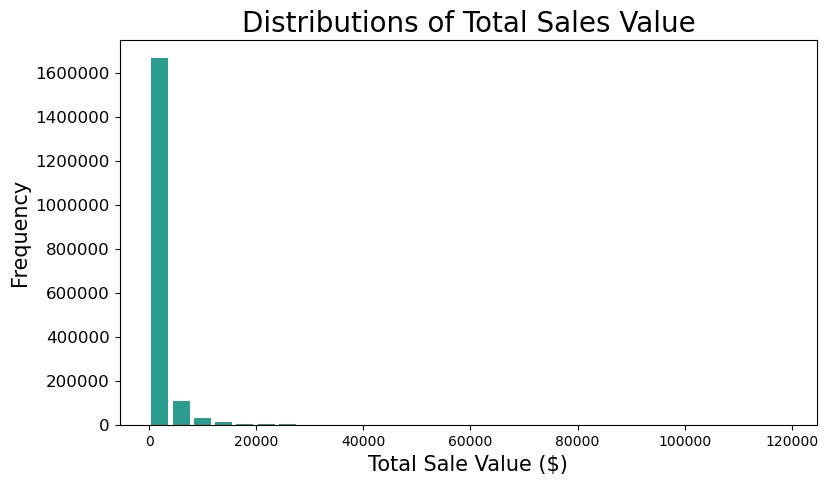

In [39]:
plt.figure(figsize = (9,5))
plt.hist(BigW_new['total_sale_value'], bins = 30, color = '#2A9D8E', rwidth = 0.8)
plt.title('Distributions of Total Sales Value', fontsize = 20)
plt.yticks(fontsize = 12)
plt.ticklabel_format(style = 'plain', axis = 'y')
plt.xlabel('Total Sale Value ($)', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)

Text(0, 0.5, 'Frequency')

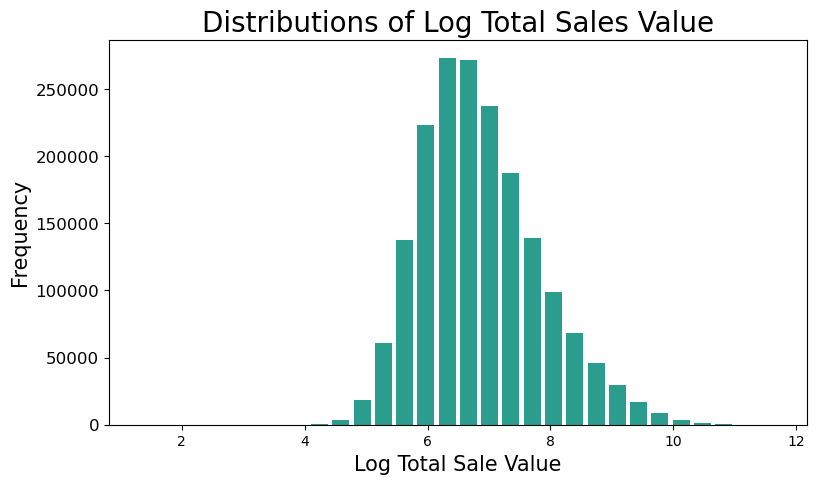

In [40]:
plt.figure(figsize = (9,5))
plt.hist(np.log(BigW_new['total_sale_value']), bins = 30, color = '#2A9D8E', rwidth = 0.8)
plt.title('Distributions of Log Total Sales Value', fontsize = 20)
plt.yticks(fontsize = 12)
plt.ticklabel_format(style = 'plain', axis = 'y')
plt.xlabel('Log Total Sale Value', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)

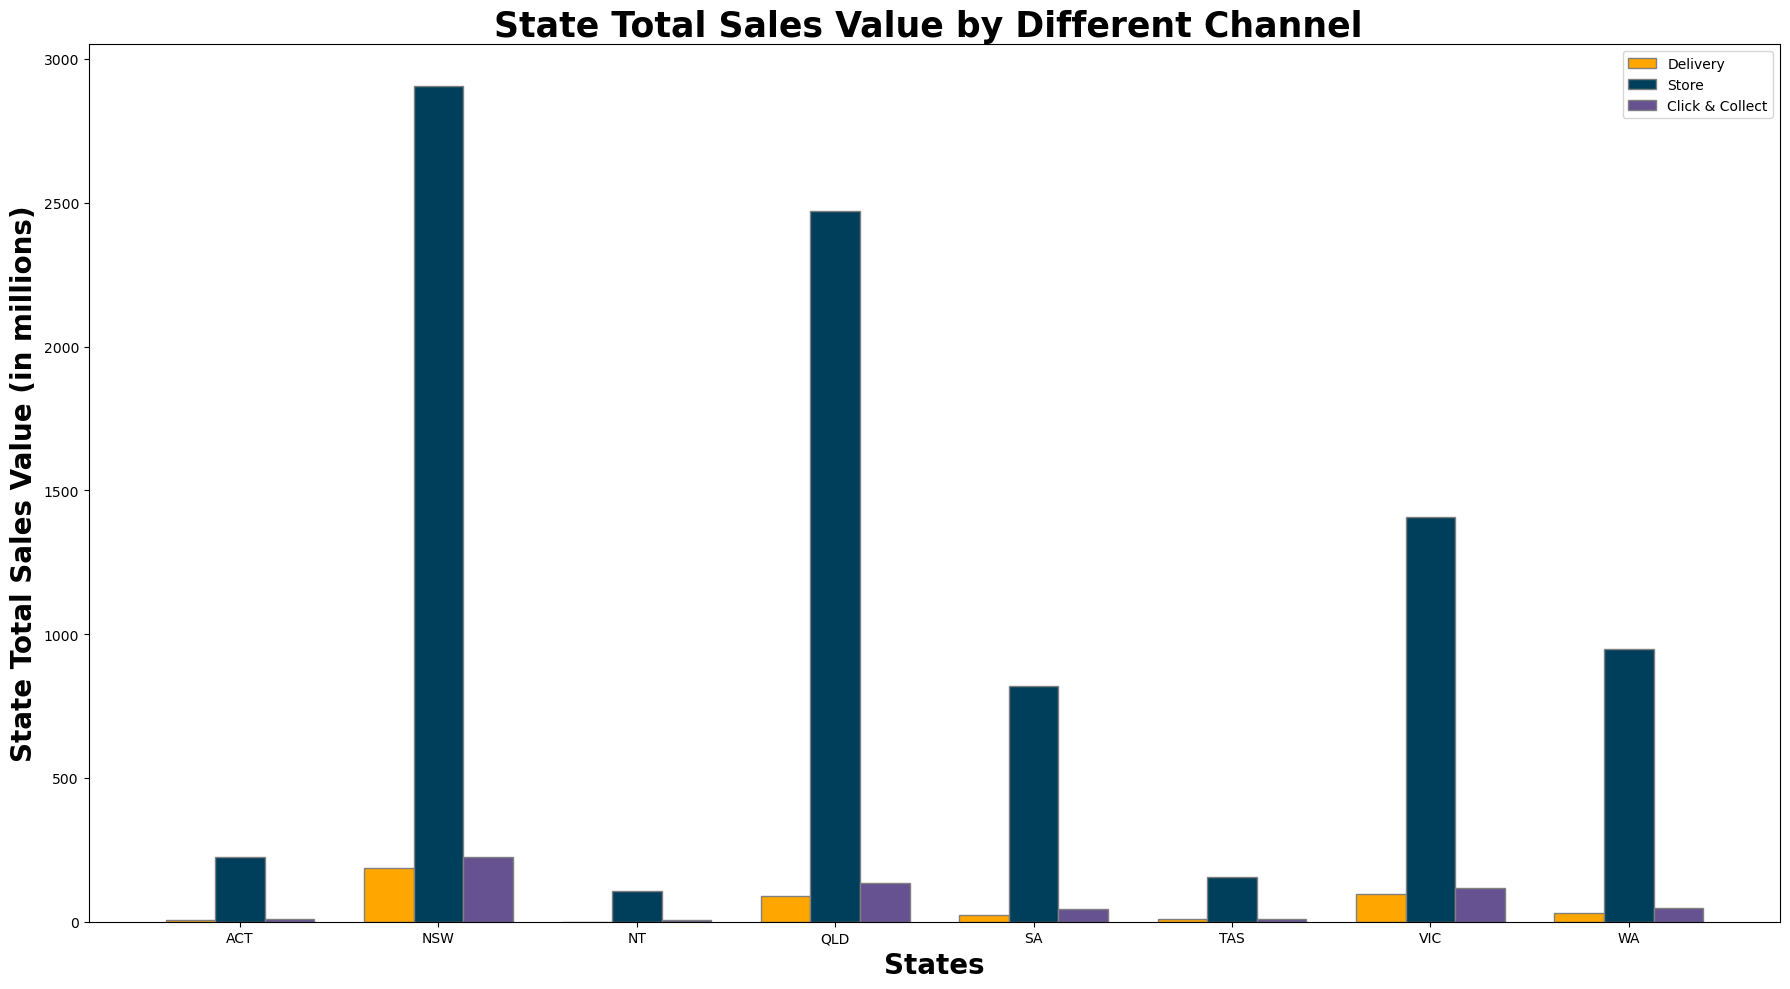

In [41]:
states = state_data['store_state']
delivery_sales = state_data['Digital - Delivery_total_sale_value'] / 1e6
store_sales = state_data['Store_total_sale_value'] / 1e6
click_collect_sales = state_data['Digital - ClickCollect_total_sale_value'] / 1e6

bar_width = 0.25
r1 = np.arange(len(states))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.figure(figsize = (18, 10))

plt.bar(r1, delivery_sales, color = '#ffa600', width = bar_width, edgecolor = 'grey', label = 'Delivery')
plt.bar(r2, store_sales, color = '#003f5c', width = bar_width, edgecolor = 'grey', label = 'Store')
plt.bar(r3, click_collect_sales, color = '#665191', width = bar_width, edgecolor = 'grey', label = 'Click & Collect')

plt.xlabel('States', fontweight = 'bold', fontsize = 20)
plt.ylabel('State Total Sales Value (in millions)', fontweight = 'bold', fontsize = 20)
plt.xticks([r + bar_width for r in range(len(states))], states)

plt.legend()

plt.title('State Total Sales Value by Different Channel ', fontweight = 'bold', fontsize = 25)
plt.tight_layout()
plt.show()

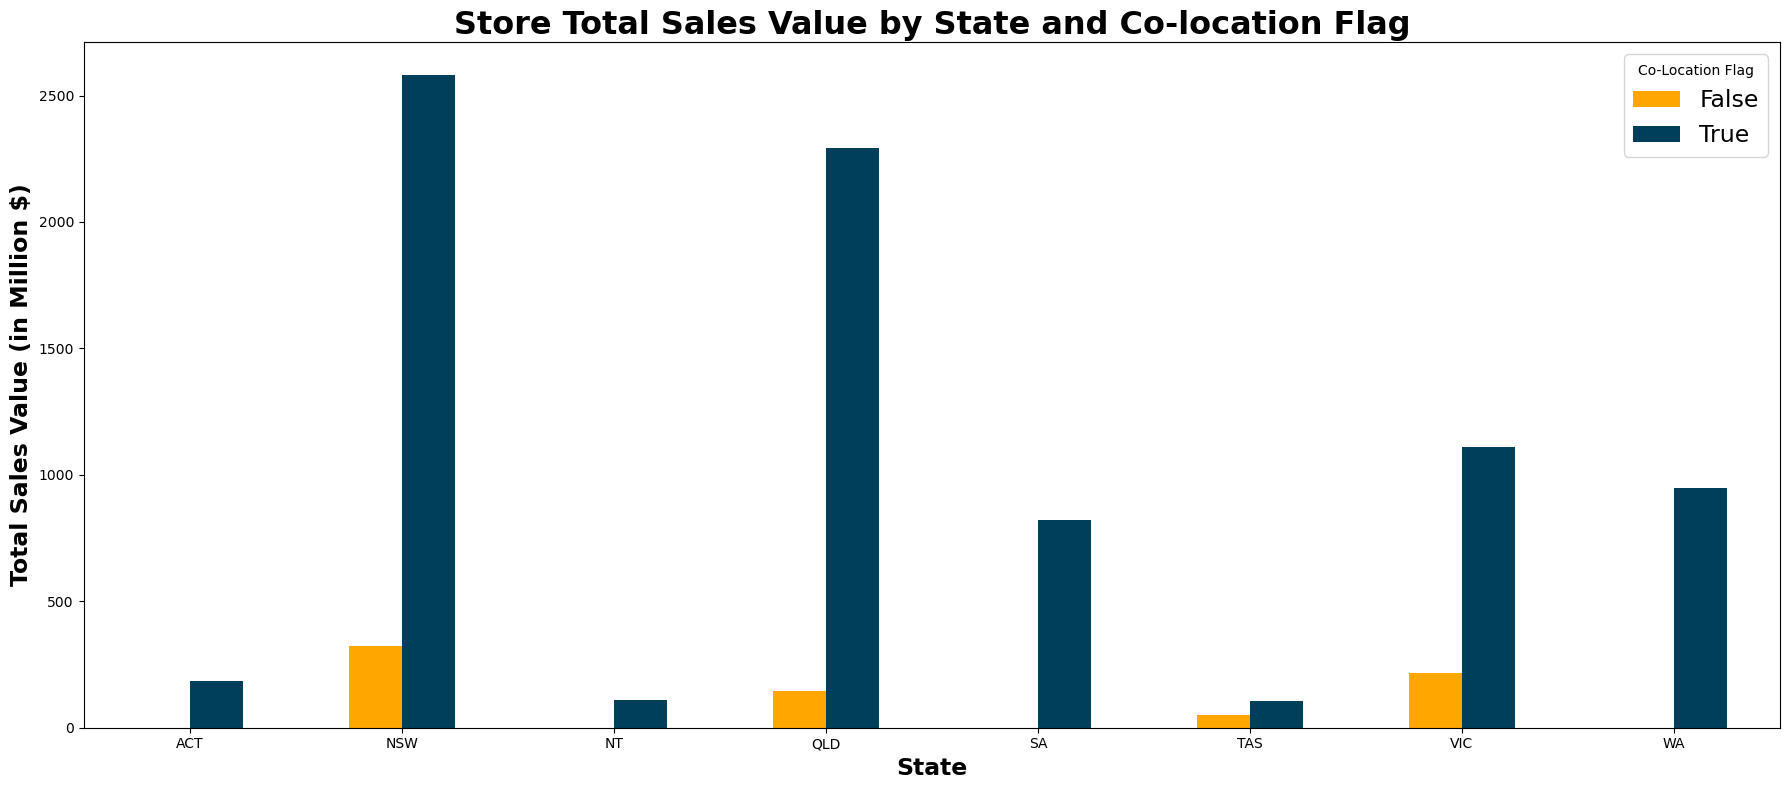

In [42]:
grouped_data = BW_sl_new.groupby(['store_state', 'co_location_flag'])['Store_total_sale_value'].sum().reset_index()

filtered_data = grouped_data[(grouped_data['Store_total_sale_value'] != 0) & (grouped_data['co_location_flag'].isin([True, False]))]

pivot_data = filtered_data.pivot_table(index = 'store_state', columns = 'co_location_flag', values = 'Store_total_sale_value', fill_value = 0)

pivot_data = pivot_data / 1000000

fig, ax = plt.subplots(figsize = (18, 8))
colors = ['#ffa600', '#003f5c', '#665191']
pivot_data.plot(kind = 'bar', stacked = False, ax = ax, color = colors)

plt.title('Store Total Sales Value by State and Co-location Flag', fontweight = 'bold', fontsize = 23)
plt.ylabel('Total Sales Value (in Million $)', fontweight = 'bold', fontsize = 17)
plt.xlabel('State', fontweight = 'bold', fontsize = 17)
plt.xticks(rotation = 360)
plt.legend(title = 'Co-Location Flag', fontsize = 17)
plt.tight_layout()
plt.show()

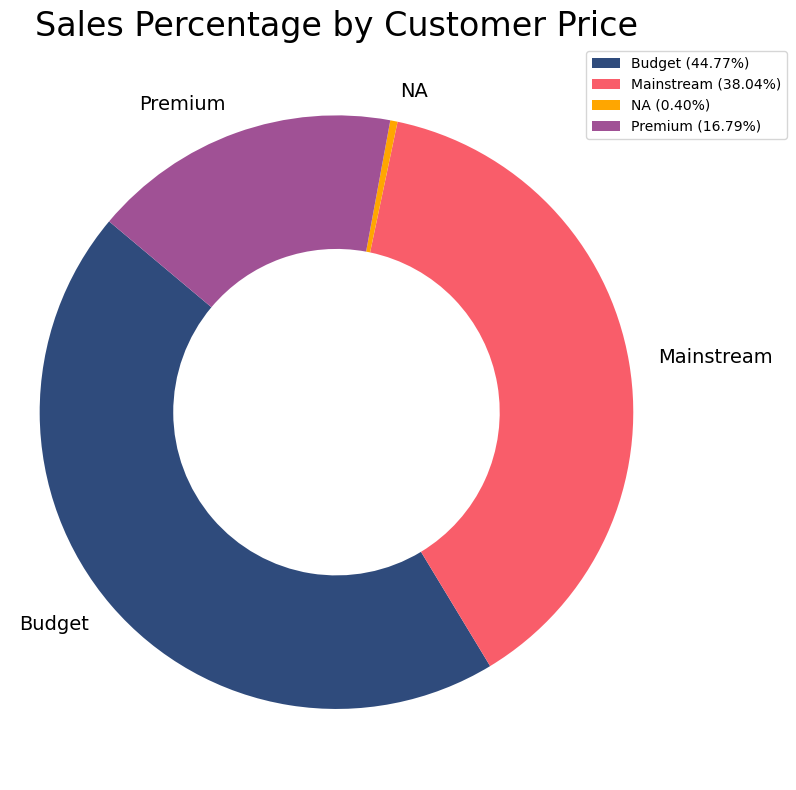

In [43]:
grouped_data_c = BigW_new.groupby('Customer_price')['total_sale_value'].sum().reset_index()

grouped_data_c['Ratios'] = grouped_data_c['total_sale_value'] / grouped_data_c['total_sale_value'].sum()

fig, ax = plt.subplots(figsize = (8, 8))

colors = ['#2f4b7c', '#f95d6a', '#ffa600', '#a05195']

wedges, texts = ax.pie(grouped_data_c['Ratios'],
                       labels = grouped_data_c['Customer_price'],
                       colors = colors,
                       startangle = 140,
                       wedgeprops = dict(width = 0.45),
                       textprops = {'fontsize': 14})

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels = [f"{price} ({ratio:.2f}%)" for price, ratio in zip(grouped_data_c['Customer_price'], grouped_data_c['Ratios']*100)],
          loc = 'upper right', bbox_to_anchor = (1.2, 1), fontsize = 10)

plt.title('Sales Percentage by Customer Price', fontsize = 24)
plt.axis('equal')
plt.tight_layout()
plt.show()

# 4. Feature Engineering

In [44]:
from sklearn.model_selection import train_test_split
train_set, vali_set = train_test_split(BigW_new, test_size = 0.25, random_state = 42)

In [45]:
X_train = train_set.drop('total_sale_value', axis = 1)
X_vali = vali_set.drop('total_sale_value', axis = 1)
X_tv = BigW_new.drop('total_sale_value', axis = 1)
X_test = BigW_test_data_new.drop('total_sale_value', axis = 1)

In [46]:
y_train = np.log(train_set['total_sale_value'])
y_vali = np.log(vali_set['total_sale_value'])
y_tv = np.log(BigW_new['total_sale_value'])
y_test = np.log(BigW_test_data_new['total_sale_value'])

In [47]:
columns_to_fill = ['People', 'Female', 'Median age', 'Families', 'All private dwellings', 
                   'Average number of people per household', 'Median weekly household income', 
                   'Median monthly mortgage repayments', 'Median weekly rent (b)', 
                   'Average number of motor vehicles per dwelling']

for column in columns_to_fill:
    fill_values = X_train.groupby('store_state')[column].transform('mean')
    X_train[column] = X_train[column].fillna(fill_values)

In [48]:
for column in columns_to_fill:
    fill_values1 = X_vali.groupby('store_state')[column].transform('mean')
    X_vali[column] = X_vali[column].fillna(fill_values1)

In [49]:
for column in columns_to_fill:
    fill_values2 = X_tv.groupby('store_state')[column].transform('mean')
    X_tv[column] = X_tv[column].fillna(fill_values2)

In [50]:
for column in columns_to_fill:
    fill_values3 = X_test.groupby('store_state')[column].transform('mean')
    X_test[column] = X_test[column].fillna(fill_values3)

In [51]:
X_train['year'] = X_train['financial_week_end_date'].dt.year
X_train['month'] = X_train['financial_week_end_date'].dt.month
X_vali['year'] = X_vali['financial_week_end_date'].dt.year
X_vali['month'] = X_vali['financial_week_end_date'].dt.month
X_tv['year'] = X_tv['financial_week_end_date'].dt.year
X_tv['month'] = X_tv['financial_week_end_date'].dt.month
X_test['year'] = X_test['financial_week_end_date'].dt.year
X_test['month'] = X_test['financial_week_end_date'].dt.month

In [52]:
predictor1 = ['Holiday Name']

encoder1 = LeaveOneOutEncoder().fit(X_train[predictor1], y_train) 
X_train['Holiday Name_en'] = encoder1.transform(X_train[predictor1])
X_vali['Holiday Name_en'] = encoder1.transform(X_vali[predictor1])
X_tv['Holiday Name_en'] = encoder1.transform(X_tv[predictor1])
X_test['Holiday Name_en'] = encoder1.transform(X_test[predictor1])

# source from QBUS6810

In [53]:
predictor2 = ['store_id']

encoder2 = LeaveOneOutEncoder().fit(X_train[predictor2], y_train) 
X_train['store_id_en'] = encoder2.transform(X_train[predictor2])
X_vali['store_id_en'] = encoder2.transform(X_vali[predictor2])
X_tv['store_id_en'] = encoder2.transform(X_tv[predictor2])
X_test['store_id_en'] = encoder2.transform(X_test[predictor2])

In [54]:
predictor3 = ['co_location_flag']

encoder3 = LeaveOneOutEncoder().fit(X_train[predictor3], y_train) 
X_train['co_location_flag_en'] = encoder3.transform(X_train[predictor3])
X_vali['co_location_flag_en'] = encoder3.transform(X_vali[predictor3])
X_tv['co_location_flag_en'] = encoder3.transform(X_tv[predictor3])
X_test['co_location_flag_en'] = encoder3.transform(X_test[predictor3])

In [55]:
predictor4 = ['distance_to_kmart']

encoder4 = LeaveOneOutEncoder().fit(X_train[predictor4], y_train) 
X_train['distance_to_kmart_en'] = encoder4.transform(X_train[predictor4])
X_vali['distance_to_kmart_en'] = encoder4.transform(X_vali[predictor4])
X_tv['distance_to_kmart_en'] = encoder4.transform(X_tv[predictor4])
X_test['distance_to_kmart_en'] = encoder4.transform(X_test[predictor4])

In [56]:
predictor5 = ['distance_to_target']

encoder5 = LeaveOneOutEncoder().fit(X_train[predictor5], y_train) 
X_train['distance_to_target_en'] = encoder5.transform(X_train[predictor5])
X_vali['distance_to_target_en'] = encoder5.transform(X_vali[predictor5])
X_tv['distance_to_target_en'] = encoder5.transform(X_tv[predictor5])
X_test['distance_to_target_en'] = encoder5.transform(X_test[predictor5])

In [57]:
predictor6 = ['Customer_price']

encoder6 = LeaveOneOutEncoder().fit(X_train[predictor6], y_train) 
X_train['Customer_price_en'] = encoder6.transform(X_train[predictor6])
X_vali['Customer_price_en'] = encoder6.transform(X_vali[predictor6])
X_tv['Customer_price_en'] = encoder6.transform(X_tv[predictor6])
X_test['Customer_price_en'] = encoder6.transform(X_test[predictor6])

In [58]:
predictor7 = ['Lifestage']

encoder7 = LeaveOneOutEncoder().fit(X_train[predictor7], y_train) 
X_train['Lifestage_en'] = encoder7.transform(X_train[predictor7])
X_vali['Lifestage_en'] = encoder7.transform(X_vali[predictor7])
X_tv['Lifestage_en'] = encoder7.transform(X_tv[predictor7])
X_test['Lifestage_en'] = encoder7.transform(X_test[predictor7])

In [59]:
predictor8 = ['sales_channel']

encoder8 = LeaveOneOutEncoder().fit(X_train[predictor8], y_train) 
X_train['sales_channel_en'] = encoder8.transform(X_train[predictor8])
X_vali['sales_channel_en'] = encoder8.transform(X_vali[predictor8])
X_tv['sales_channel_en'] = encoder8.transform(X_tv[predictor8])
X_test['sales_channel_en'] = encoder8.transform(X_test[predictor8])

In [60]:
X_train['financial_week_end_date'] = X_train['financial_week_end_date'].astype(str)
X_vali['financial_week_end_date'] = X_vali['financial_week_end_date'].astype(str)
X_tv['financial_week_end_date'] = X_tv['financial_week_end_date'].astype(str)
X_test['financial_week_end_date'] = X_test['financial_week_end_date'].astype(str)

predictor11 = ['financial_week_end_date']

encoder11 = LeaveOneOutEncoder().fit(X_train[predictor11], y_train) 
X_train['financial_week_end_date_en'] = encoder11.transform(X_train[predictor11])
X_vali['financial_week_end_date_en'] = encoder11.transform(X_vali[predictor11])
X_tv['financial_week_end_date_en'] = encoder11.transform(X_tv[predictor11])
X_test['financial_week_end_date_en'] = encoder11.transform(X_test[predictor11])

In [61]:
predictor12 = ['store_state']

encoder12 = LeaveOneOutEncoder().fit(X_train[predictor12], y_train) 
X_train['store_state_en'] = encoder12.transform(X_train[predictor12])
X_vali['store_state_en'] = encoder12.transform(X_vali[predictor12])
X_tv['store_state_en'] = encoder12.transform(X_tv[predictor12])
X_test['store_state_en'] = encoder12.transform(X_test[predictor12])

In [62]:
X_train['store_postcode'] = X_train['store_postcode'].astype(str)
X_vali['store_postcode'] = X_vali['store_postcode'].astype(str)
X_tv['store_postcode'] = X_tv['store_postcode'].astype(str)
X_test['store_postcode'] = X_test['store_postcode'].astype(str)
predictor13 = ['store_postcode']

encoder13 = LeaveOneOutEncoder().fit(X_train[predictor13], y_train) 
X_train['store_postcode_en'] = encoder13.transform(X_train[predictor13])
X_vali['store_postcode_en'] = encoder13.transform(X_vali[predictor13])
X_tv['store_postcode_en'] = encoder13.transform(X_tv[predictor13])
X_test['store_postcode_en'] = encoder13.transform(X_test[predictor13])

In [63]:
X_train['year'] = X_train['year'].astype(str)
X_vali['year'] = X_vali['year'].astype(str)
X_tv['year'] = X_tv['year'].astype(str)
X_test['year'] = X_test['year'].astype(str)

predictor14 = ['year']

encoder14 = LeaveOneOutEncoder().fit(X_train[predictor14], y_train) 
X_train['year_en'] = encoder14.transform(X_train[predictor14])
X_vali['year_en'] = encoder14.transform(X_vali[predictor14])
X_tv['year_en'] = encoder14.transform(X_tv[predictor14])
X_test['year_en'] = encoder14.transform(X_test[predictor14])

In [64]:
X_train['month'] = X_train['month'].astype(str)
X_vali['month'] = X_vali['month'].astype(str)
X_tv['month'] = X_tv['month'].astype(str)
X_test['month'] = X_test['month'].astype(str)

predictor15 = ['month']

encoder15 = LeaveOneOutEncoder().fit(X_train[predictor15], y_train) 
X_train['month_en'] = encoder15.transform(X_train[predictor15])
X_vali['month_en'] = encoder15.transform(X_vali[predictor15])
X_tv['month_en'] = encoder15.transform(X_tv[predictor15])
X_test['month_en'] = encoder15.transform(X_test[predictor15])

In [65]:
train_features = set(X_train.columns)
vali_features = set(X_vali.columns)
tv_features = set(X_tv.columns)
test_features = set(X_test.columns)

if train_features == vali_features == tv_features == test_features:
    print('yes')
else:
    print('no')

yes


## 4.1 Feature Selection

In [66]:
df_combined = X_train.copy()
df_combined['log_total_sale_value'] = y_train

correlation_matrix = df_combined.corr()

target_correlation = correlation_matrix['log_total_sale_value'].drop('log_total_sale_value')
sorted_target_correlation = target_correlation.sort_values(ascending=False)
print(sorted_target_correlation)

store_id_en                                      0.33
store_postcode_en                                0.32
Lifestage_en                                     0.19
Average number of motor vehicles per dwelling    0.15
Customer_price_en                                0.14
distance_to_kmart_en                             0.14
financial_week_end_date_en                       0.12
store_state_en                                   0.11
month_en                                         0.11
Families                                         0.09
distance_to_target_en                            0.09
People                                           0.09
co_location_flag_en                              0.08
All private dwellings                            0.08
store_latitude                                   0.08
Median age                                       0.07
Average number of people per household           0.06
Holiday Name_en                                  0.06
year_en                     

In [67]:
fl = ['media_amount_spend',
      'People',
      'Female',
      'Median age',
      'Families',
      'All private dwellings',
      'Average number of people per household',
      'Median weekly household income',
      'Median monthly mortgage repayments',
      'Median weekly rent (b)',
      'Average number of motor vehicles per dwelling',
      'Holiday Name_en',
      'store_id_en',
      'co_location_flag_en',
      'distance_to_kmart_en',
      'distance_to_target_en',
      'Customer_price_en',
      'Lifestage_en',
      'sales_channel_en',
      'financial_week_end_date_en',
      'store_state_en',
      'store_postcode_en',
      'year_en',
      'month_en']

In [68]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

model = LinearRegression()

rfe = RFE(model)
fit = rfe.fit(X_train[fl], y_train)

selected_features = X_train[fl].columns[fit.ranking_ == 1]

feature_rankings = fit.ranking_

features_with_rankings = list(zip(X_train[fl].columns, feature_rankings))

for feature, rank in sorted(features_with_rankings, key = lambda x: x[1]):
    print(f"Feature: {feature}, Rank: {rank}")

Feature: Female, Rank: 1
Feature: Average number of motor vehicles per dwelling, Rank: 1
Feature: Holiday Name_en, Rank: 1
Feature: store_id_en, Rank: 1
Feature: distance_to_target_en, Rank: 1
Feature: Customer_price_en, Rank: 1
Feature: Lifestage_en, Rank: 1
Feature: sales_channel_en, Rank: 1
Feature: financial_week_end_date_en, Rank: 1
Feature: store_state_en, Rank: 1
Feature: year_en, Rank: 1
Feature: month_en, Rank: 1
Feature: Average number of people per household, Rank: 2
Feature: co_location_flag_en, Rank: 3
Feature: store_postcode_en, Rank: 4
Feature: distance_to_kmart_en, Rank: 5
Feature: Median age, Rank: 6
Feature: Median weekly rent (b), Rank: 7
Feature: Median weekly household income, Rank: 8
Feature: Median monthly mortgage repayments, Rank: 9
Feature: Families, Rank: 10
Feature: All private dwellings, Rank: 11
Feature: People, Rank: 12
Feature: media_amount_spend, Rank: 13


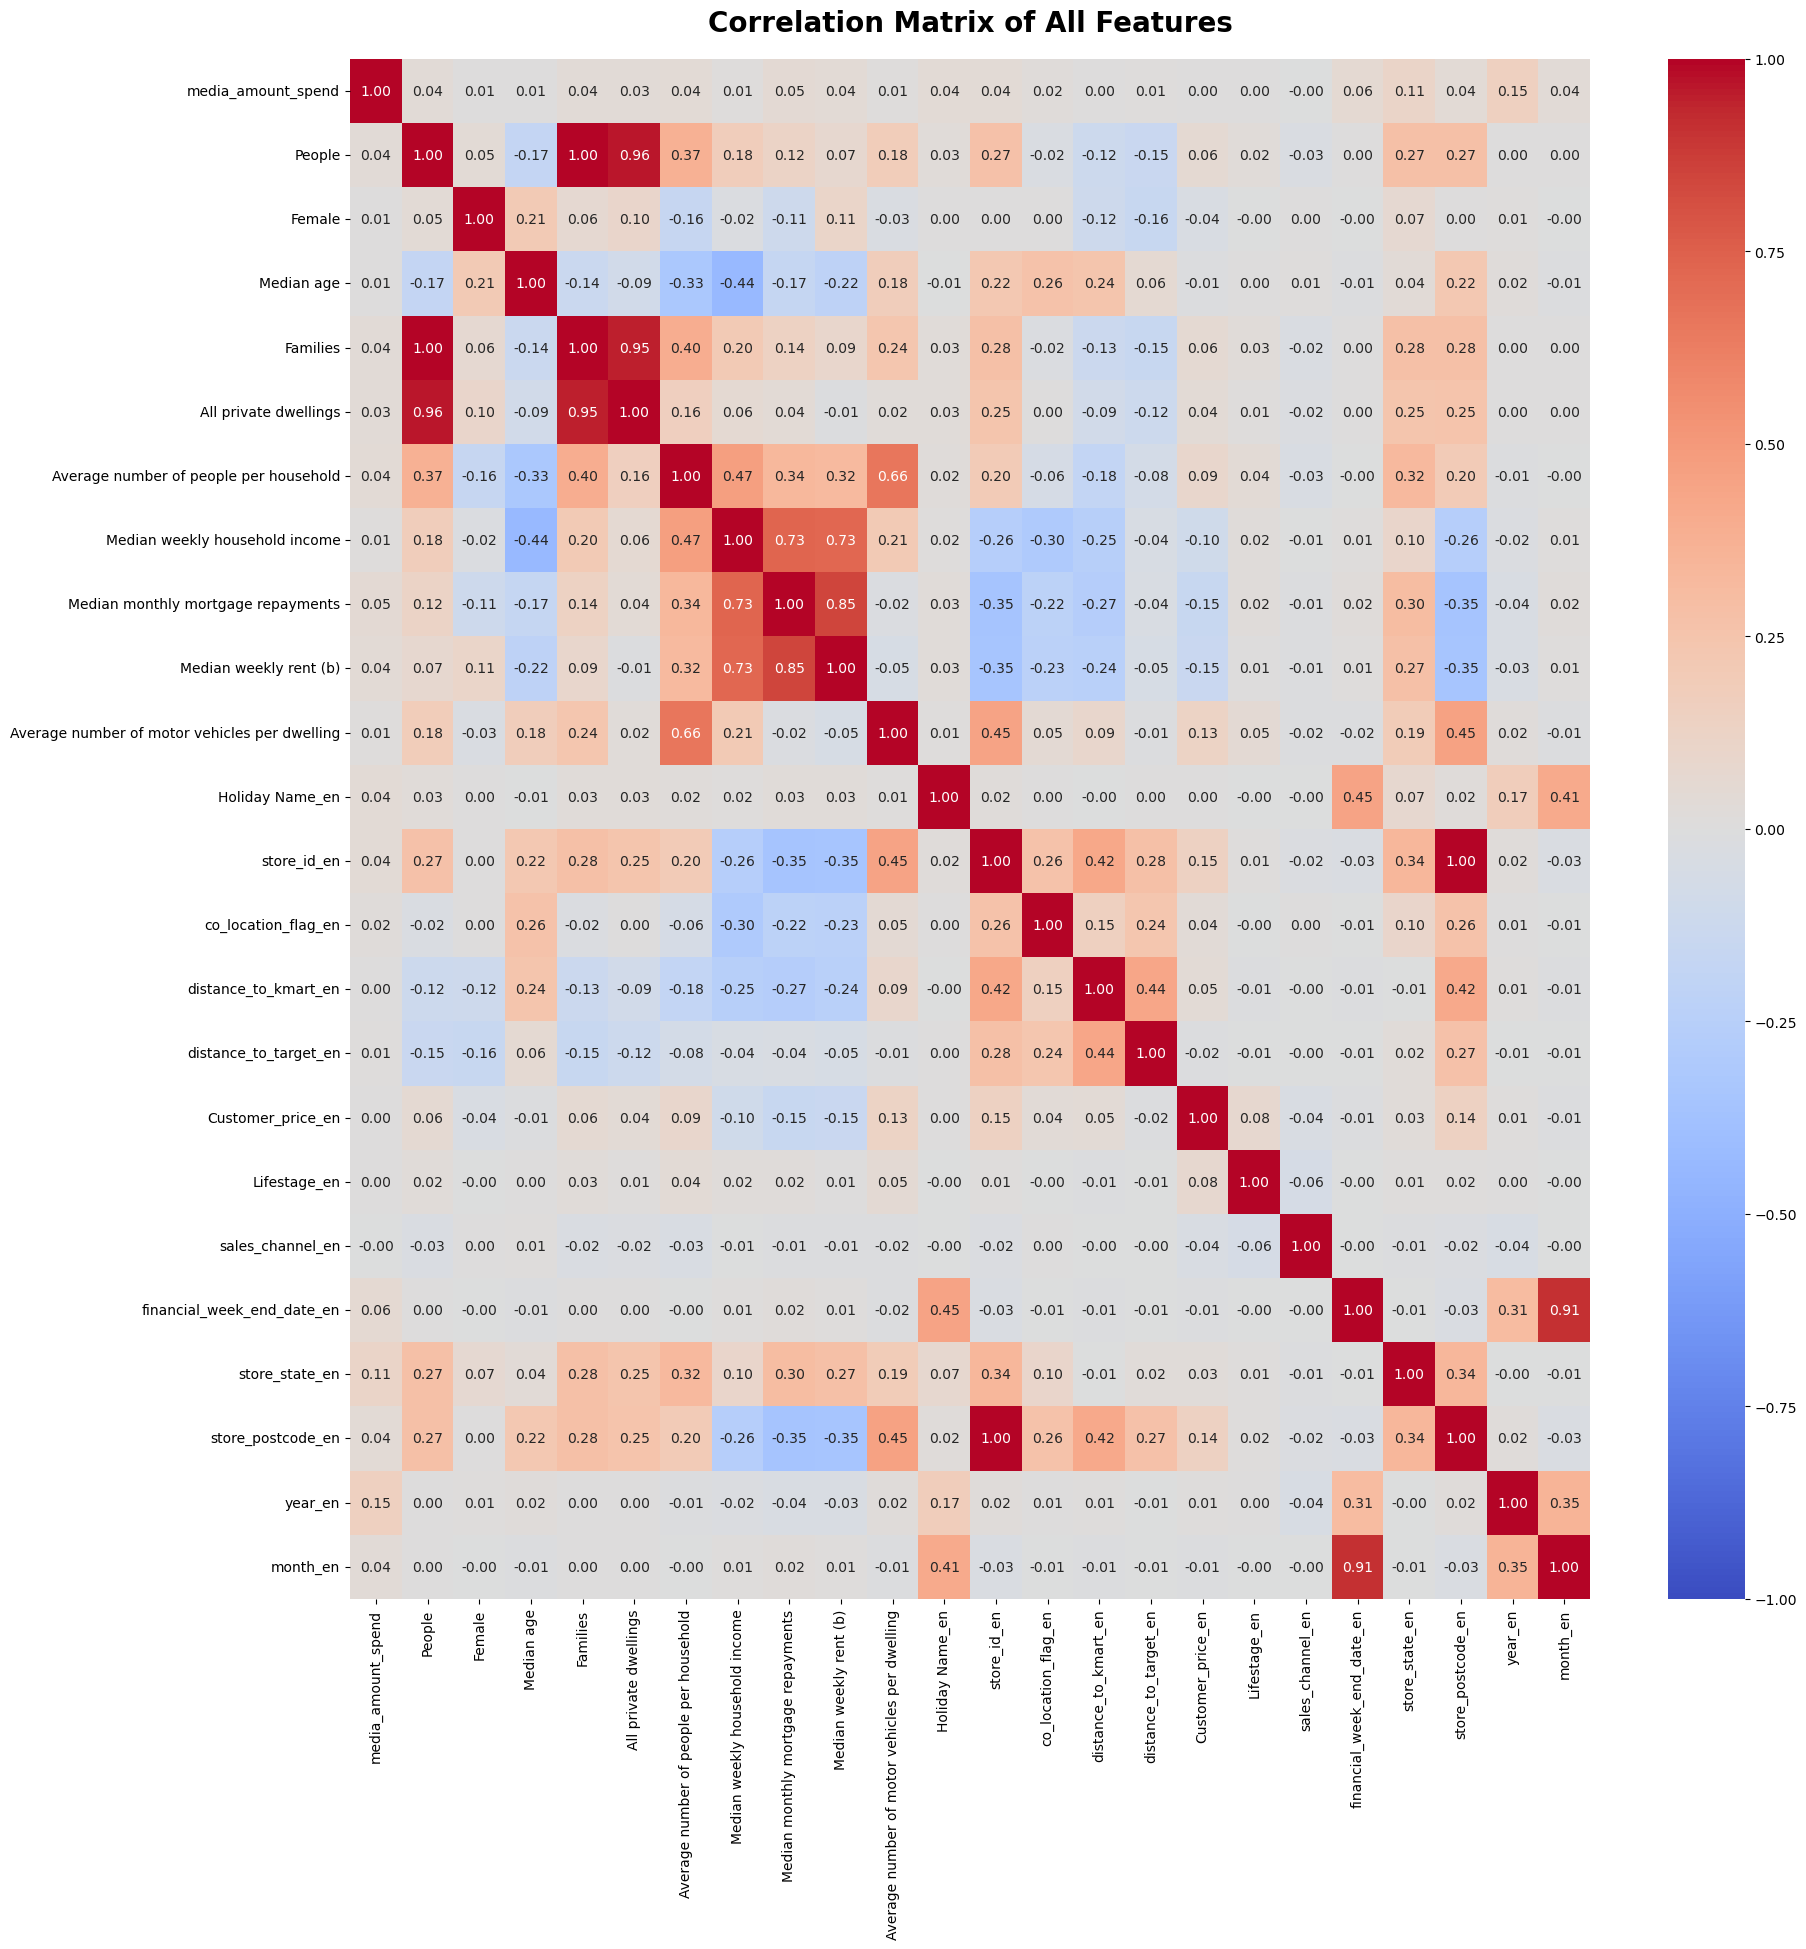

In [69]:
corr_matrix = X_train[fl].corr()

plt.figure(figsize = (20, 20))
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, fmt = ".2f")
plt.title('Correlation Matrix of All Features', fontsize = 20, fontweight = 'bold', pad = 20)
plt.show()

In [70]:
sfl = ['Lifestage_en',
       'Average number of motor vehicles per dwelling',
       'Customer_price_en',
       'distance_to_kmart_en',
       'financial_week_end_date_en',
       'store_state_en',
       'distance_to_target_en',
       'People',
       'co_location_flag_en',
       'Median age',
       'Holiday Name_en',
       'sales_channel_en',
       'Female',
       'Median weekly household income',
       'store_postcode_en']

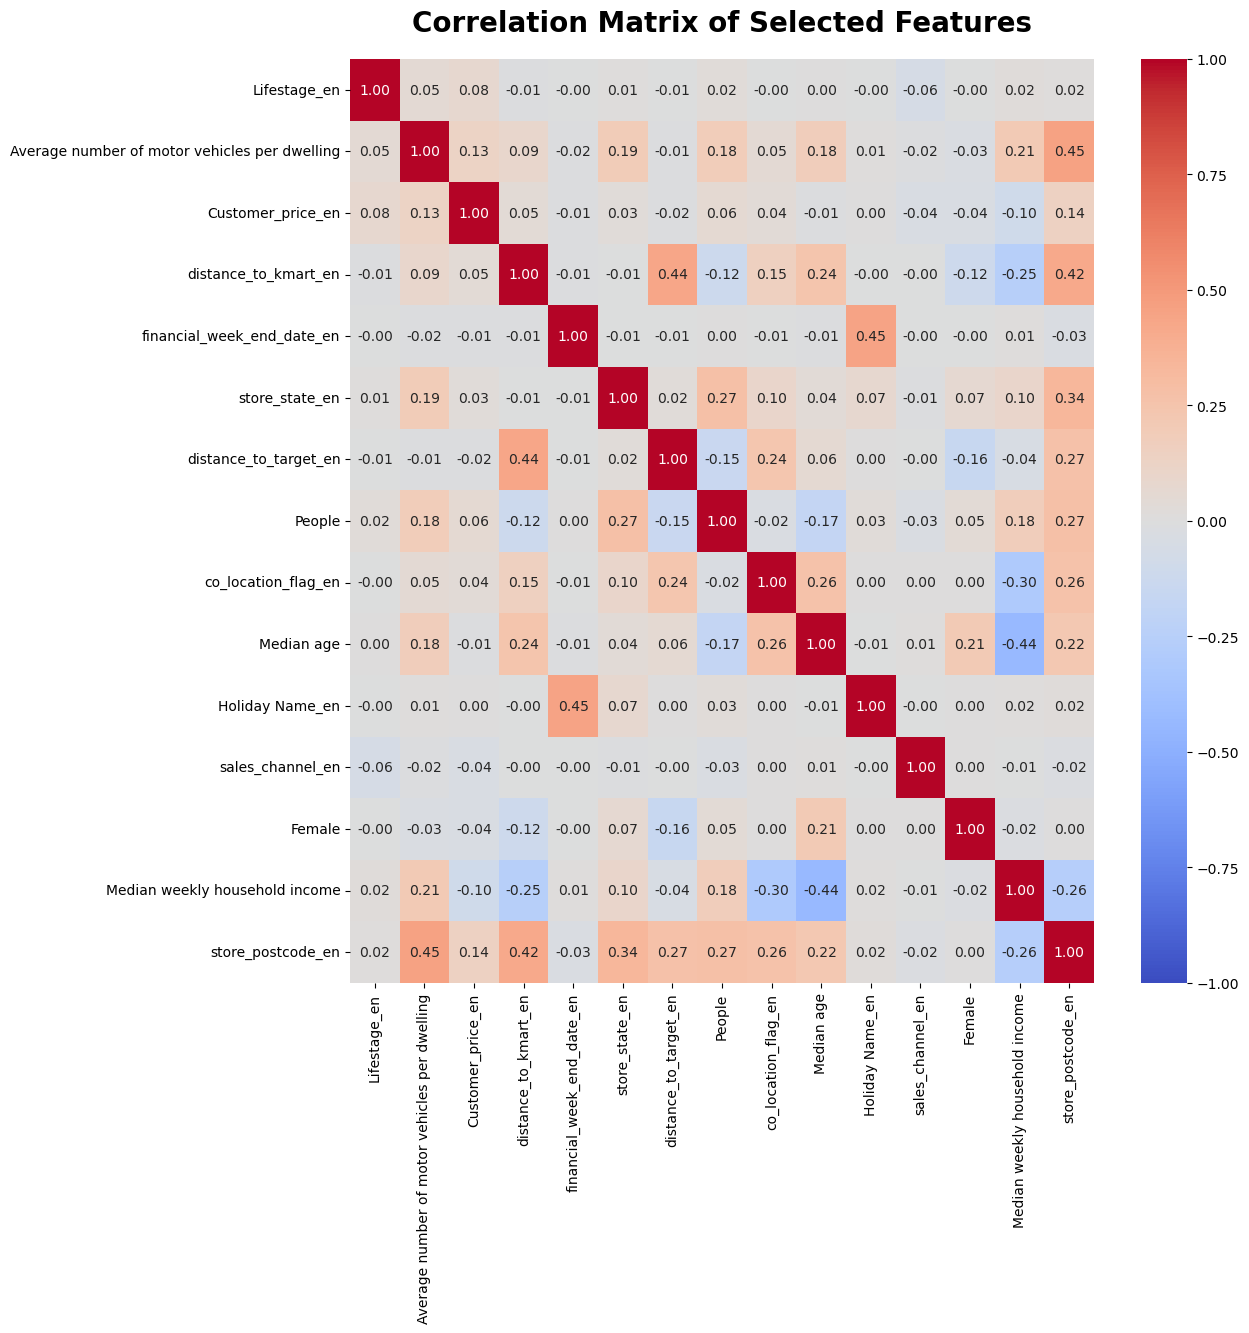

In [71]:
corr_matrix_sfl = X_train[sfl].corr()

plt.figure(figsize = (12, 12))
sns.heatmap(corr_matrix_sfl, annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, fmt = ".2f")
plt.title('Correlation Matrix of Selected Features', fontsize = 20, fontweight = 'bold', pad = 20)
plt.show()

# 5. Model

## Linear Model

### 5.1 OLS

In [72]:
from sklearn.linear_model import LinearRegression

OLSModel = LinearRegression(fit_intercept = True)
OLSModel.fit(X_train[sfl], y_train)

# source from QBUS6810

LinearRegression()

In [73]:
OLSModel_coe = pd.DataFrame(np.c_[X_train[sfl].columns, OLSModel.coef_],
                                columns = ['Feature','Coefficient'])
OLSModel_coe

# source from QBUS6810

,Feature,Coefficient
0,Lifestage_en,0.96
1,Average number of motor vehicles per dwelling,-0.07
2,Customer_price_en,0.61
3,distance_to_kmart_en,0.04
4,financial_week_end_date_en,1.08
5,store_state_en,0.01
6,distance_to_target_en,0.04
7,People,-0.00
8,co_location_flag_en,-0.01
9,Median age,0.00


In [74]:
OLSModel_pre = OLSModel.predict(X_vali[sfl])

In [75]:
Fit_OLSModel = OLSModel.predict(X_train[sfl])
Re_OLSModel = (np.exp(y_train - Fit_OLSModel)).mean()
Pvali_OLSModel = np.exp(OLSModel_pre) * Re_OLSModel
Pvali_OLSModel_r2_score = r2_score((vali_set['total_sale_value']), Pvali_OLSModel)
Pvali_OLSModel_rmse = np.sqrt(mse((vali_set['total_sale_value']), Pvali_OLSModel))

# source from QBUS6810

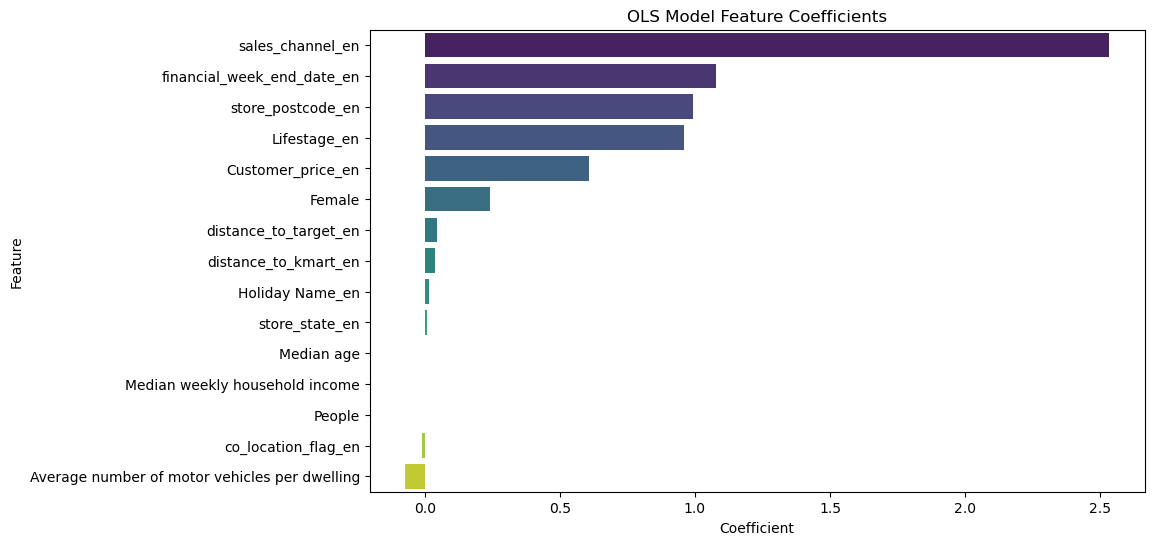

In [76]:
plt.figure(figsize = (10, 6))
coefficients = OLSModel_coe.sort_values(by = 'Coefficient', ascending = False)
sns.barplot(data = coefficients, x = 'Coefficient', y = 'Feature', palette = 'viridis')
plt.title('OLS Model Feature Coefficients')
plt.show()

(array([-20000.,      0.,  20000.,  40000.,  60000.,  80000., 100000.,
        120000.]),
 [Text(0, -20000.0, '−20000'),
  Text(0, 0.0, '0'),
  Text(0, 20000.0, '20000'),
  Text(0, 40000.0, '40000'),
  Text(0, 60000.0, '60000'),
  Text(0, 80000.0, '80000'),
  Text(0, 100000.0, '100000'),
  Text(0, 120000.0, '120000')])

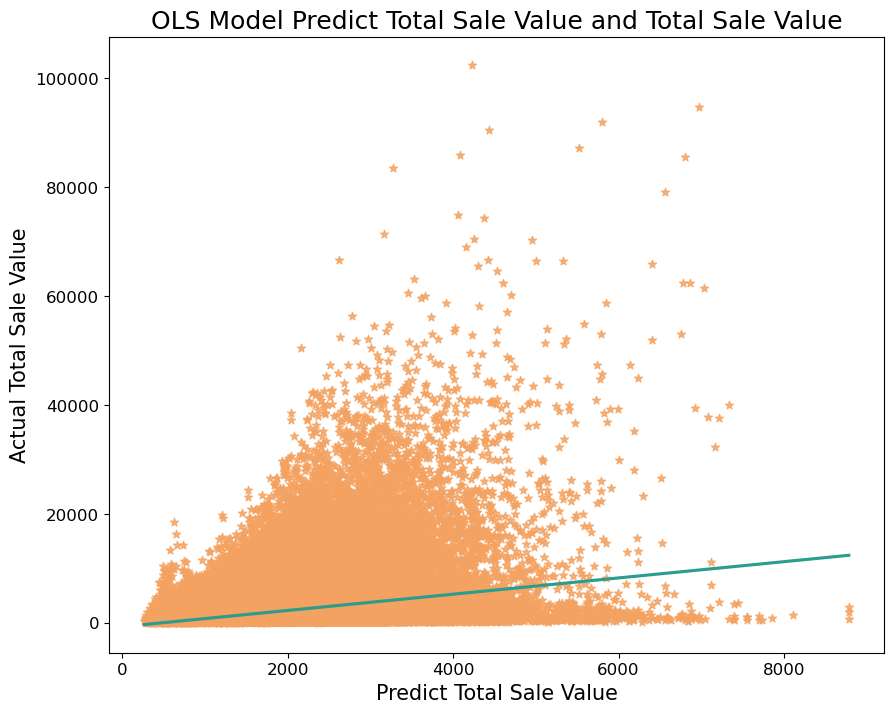

In [77]:
plt.figure(figsize = (10,8))
sns.regplot(x = Pvali_OLSModel, 
            y = (vali_set['total_sale_value']), 
            marker = '*',
            color = '#F3A261',
            line_kws={'color':'#2A9D8E'})
plt.title('OLS Model Predict Total Sale Value and Total Sale Value', fontsize = 18)
plt.xlabel('Predict Total Sale Value', fontsize = 15)
plt.ylabel('Actual Total Sale Value', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

### 5.2 Elastic Net Model

In [78]:
from sklearn.linear_model import ElasticNetCV

l1_ratios = np.linspace(0.01, 0.99, 20)

ENModel = ElasticNetCV(l1_ratio = l1_ratios, cv = 5)

ENModel.fit(X_train[sfl], y_train)

# source from QBUS6810

ElasticNetCV(cv=5,
             l1_ratio=array([0.01      , 0.06157895, 0.11315789, 0.16473684, 0.21631579,
       0.26789474, 0.31947368, 0.37105263, 0.42263158, 0.47421053,
       0.52578947, 0.57736842, 0.62894737, 0.68052632, 0.73210526,
       0.78368421, 0.83526316, 0.88684211, 0.93842105, 0.99      ]))

In [79]:
best_alpha = ENModel.alpha_
best_l1_ratio = ENModel.l1_ratio_
print('Best alpha:', best_alpha)
print('Best l1_ratio:', best_l1_ratio)

Best alpha: 1.8840483983699492
Best l1_ratio: 0.99


In [80]:
EN_pre = ENModel.predict(X_vali[sfl])

In [81]:
Fit_ENModel = ENModel.predict(X_train[sfl])
Re_ENModel = (np.exp(y_train - Fit_ENModel)).mean()
Pvali_ENModel = np.exp(EN_pre) * Re_ENModel
Pvali_ENModel_r2_score = r2_score((vali_set['total_sale_value']), Pvali_ENModel)
Pvali_ENModel_rmse = np.sqrt(mse((vali_set['total_sale_value']), Pvali_ENModel))

# source from QBUS6810

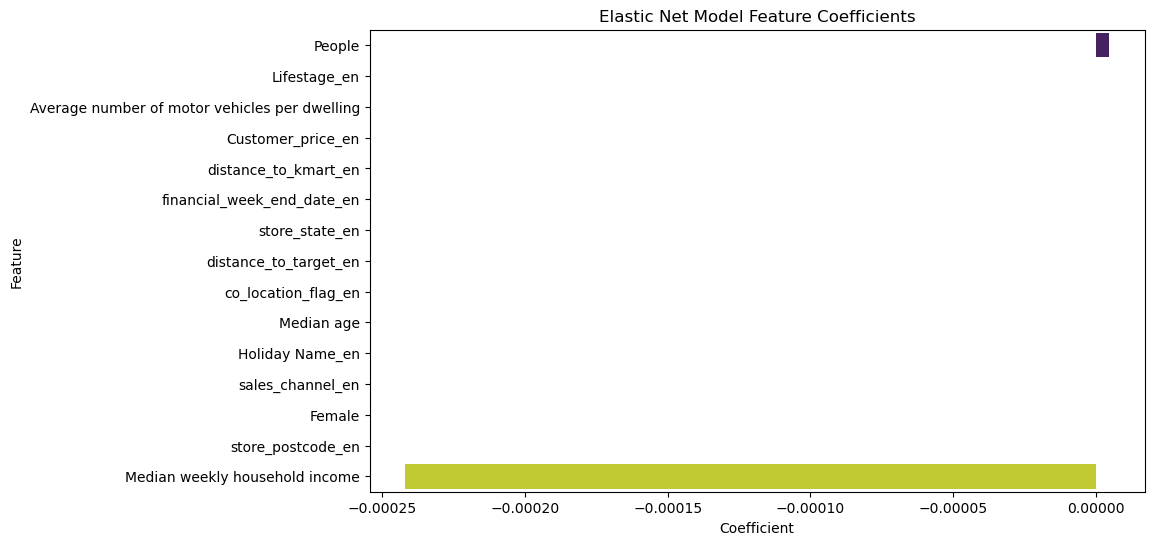

In [82]:
# Plot the coefficients
coefficients = pd.DataFrame({
    'Feature': X_train[sfl].columns,
    'Coefficient': ENModel.coef_
}).sort_values(by = 'Coefficient', ascending=False)

plt.figure(figsize = (10, 6))
sns.barplot(data = coefficients, x = 'Coefficient', y = 'Feature', palette = 'viridis')
plt.title('Elastic Net Model Feature Coefficients')
plt.show()

(array([-20000.,      0.,  20000.,  40000.,  60000.,  80000., 100000.,
        120000.]),
 [Text(0, -20000.0, '−20000'),
  Text(0, 0.0, '0'),
  Text(0, 20000.0, '20000'),
  Text(0, 40000.0, '40000'),
  Text(0, 60000.0, '60000'),
  Text(0, 80000.0, '80000'),
  Text(0, 100000.0, '100000'),
  Text(0, 120000.0, '120000')])

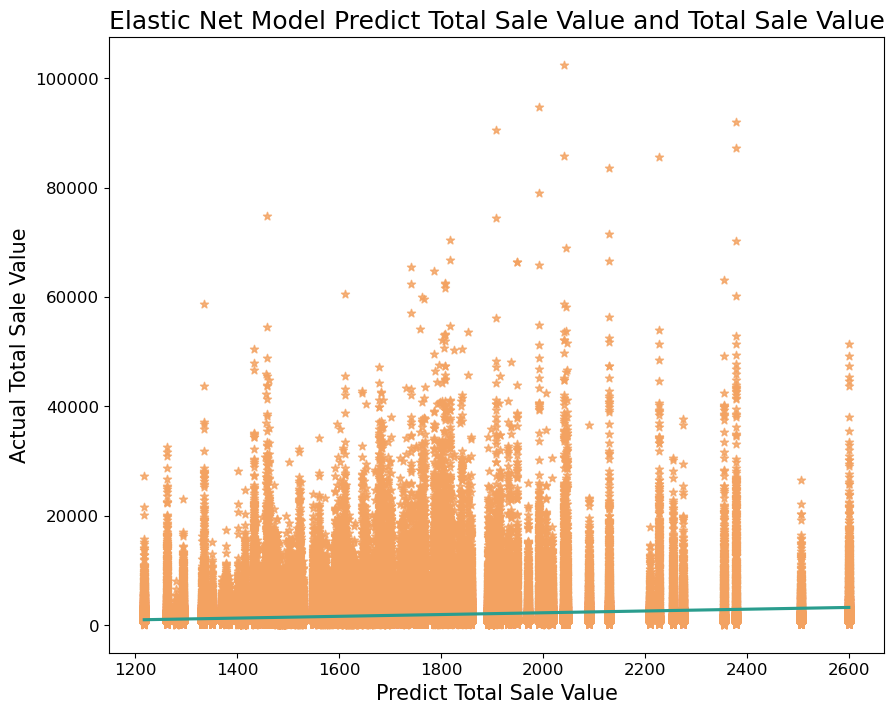

In [83]:
plt.figure(figsize = (10,8))
sns.regplot(x = Pvali_ENModel, 
            y = (vali_set['total_sale_value']), 
            marker = '*',
            color = '#F3A261',
            line_kws={'color':'#2A9D8E'})
plt.title('Elastic Net Model Predict Total Sale Value and Total Sale Value', fontsize = 18)
plt.xlabel('Predict Total Sale Value', fontsize = 15)
plt.ylabel('Actual Total Sale Value', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

### 5.3 Lasso

In [84]:
from sklearn.linear_model import LassoCV

lasso = LassoCV(cv = 5)
lasso.fit(X_train[sfl], y_train)

LassoCV(cv=5)

In [85]:
print("Best alpha : ", lasso.alpha_)

Best alpha :  1.8652079143862499


In [86]:
LassoModel_pre = lasso.predict(X_vali[sfl])

In [87]:
Fit_lasso = lasso.predict(X_train[sfl])
Re_lasso = (np.exp(y_train - Fit_lasso)).mean()
Pvali_lasso = np.exp(LassoModel_pre) * Re_lasso
Pvali_lasso_r2_score = r2_score((vali_set['total_sale_value']), Pvali_lasso)
Pvali_lasso_rmse = np.sqrt(mse((vali_set['total_sale_value']), Pvali_lasso))

# source from QBUS6810

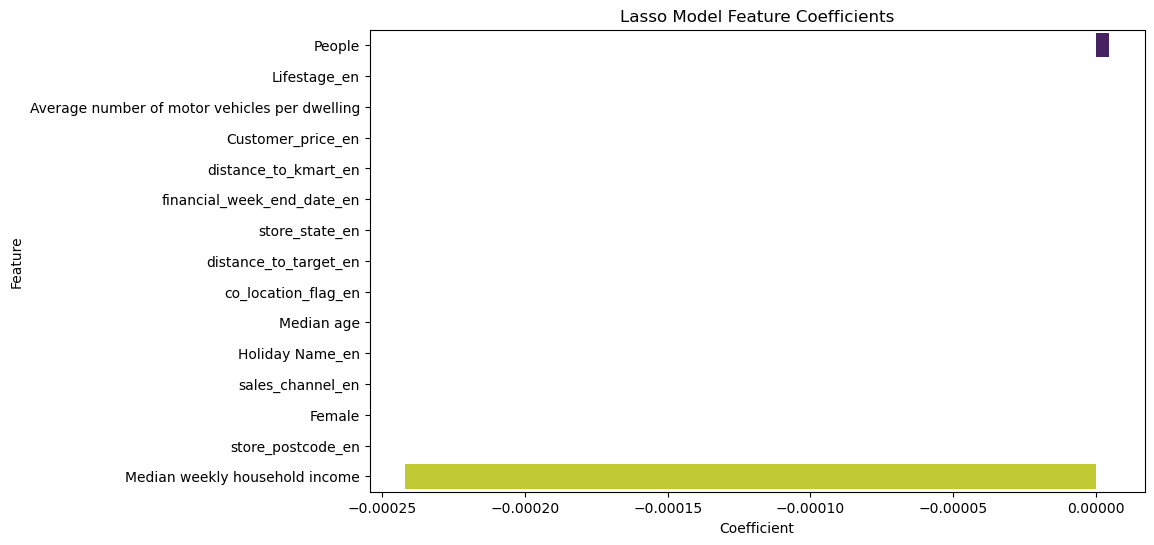

In [88]:
# Display the coefficients of the model
coefficients = pd.DataFrame({
    'Feature': X_train[sfl].columns,
    'Coefficient': lasso.coef_
}).sort_values(by = 'Coefficient', ascending = False)

plt.figure(figsize = (10, 6))
sns.barplot(data = coefficients, x = 'Coefficient', y = 'Feature', palette = 'viridis')
plt.title('Lasso Model Feature Coefficients')
plt.show()


(array([-20000.,      0.,  20000.,  40000.,  60000.,  80000., 100000.,
        120000.]),
 [Text(0, -20000.0, '−20000'),
  Text(0, 0.0, '0'),
  Text(0, 20000.0, '20000'),
  Text(0, 40000.0, '40000'),
  Text(0, 60000.0, '60000'),
  Text(0, 80000.0, '80000'),
  Text(0, 100000.0, '100000'),
  Text(0, 120000.0, '120000')])

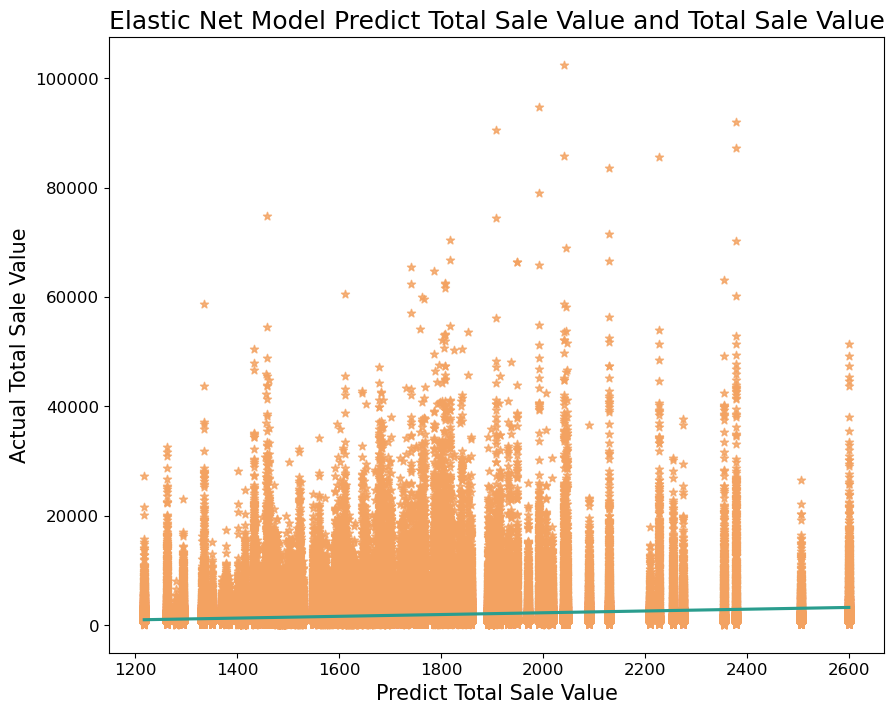

In [89]:
plt.figure(figsize = (10,8))
sns.regplot(x = Pvali_ENModel, 
            y = (vali_set['total_sale_value']), 
            marker = '*',
            color = '#F3A261',
            line_kws = {'color':'#2A9D8E'})
plt.title('Elastic Net Model Predict Total Sale Value and Total Sale Value', fontsize = 18)
plt.xlabel('Predict Total Sale Value', fontsize = 15)
plt.ylabel('Actual Total Sale Value', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

## Tree Model

### 5.4 Decision Tree

In [90]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()

param_dist = {"max_depth": range(1, 20),
              "min_samples_split": range(2, 20),
              "min_samples_leaf": range(1, 20),
              "ccp_alpha": np.linspace(0, 0.1, 10)
              }

tree_search = RandomizedSearchCV(model, param_dist, cv = 5, n_iter = 200, n_jobs = -1, random_state = 42)

tree_search.fit(X_train[sfl], y_train)

print('Best parameters found by random search:', tree_search.best_params_, '\n')

best_model = tree_search.best_estimator_

# source from QBUS6810

Best parameters found by random search: {'min_samples_split': 3, 'min_samples_leaf': 11, 'max_depth': 12, 'ccp_alpha': 0.0} 



In [91]:
best_tree_pre = best_model.predict(X_vali[sfl])

In [92]:
Fit_DTModel = best_model.predict(X_train[sfl])
Re_DTModel = (np.exp(y_train - Fit_DTModel)).mean()
Pvali_DTModel = np.exp(best_tree_pre) * Re_DTModel
Pvali_DTModel_r2_score = r2_score((vali_set['total_sale_value']), Pvali_DTModel)
Pvali_DTModel_rmse = np.sqrt(mse((vali_set['total_sale_value']), Pvali_DTModel))

# source from QBUS6810

In [93]:
print(best_model.feature_importances_)

[0.20098793 0.0102382  0.0719444  0.00364899 0.0879662  0.00564746
 0.00573476 0.01335579 0.00067607 0.01319102 0.00095539 0.02272421
 0.01264747 0.02172268 0.52855944]


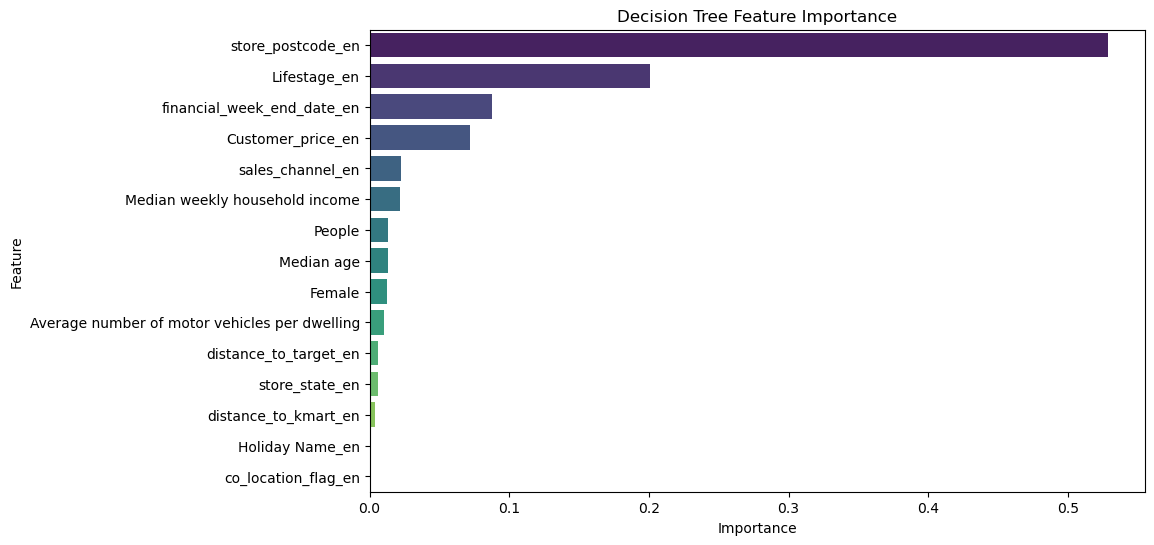

In [94]:
coefficients = pd.DataFrame({
    'Feature': X_train[sfl].columns,
    'Importance': best_model.feature_importances_
}).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (10, 6))
sns.barplot(data = coefficients, x = 'Importance', y = 'Feature', palette = 'viridis')
plt.title('Decision Tree Feature Importance')
plt.show()

(array([-20000.,      0.,  20000.,  40000.,  60000.,  80000., 100000.,
        120000.]),
 [Text(0, -20000.0, '−20000'),
  Text(0, 0.0, '0'),
  Text(0, 20000.0, '20000'),
  Text(0, 40000.0, '40000'),
  Text(0, 60000.0, '60000'),
  Text(0, 80000.0, '80000'),
  Text(0, 100000.0, '100000'),
  Text(0, 120000.0, '120000')])

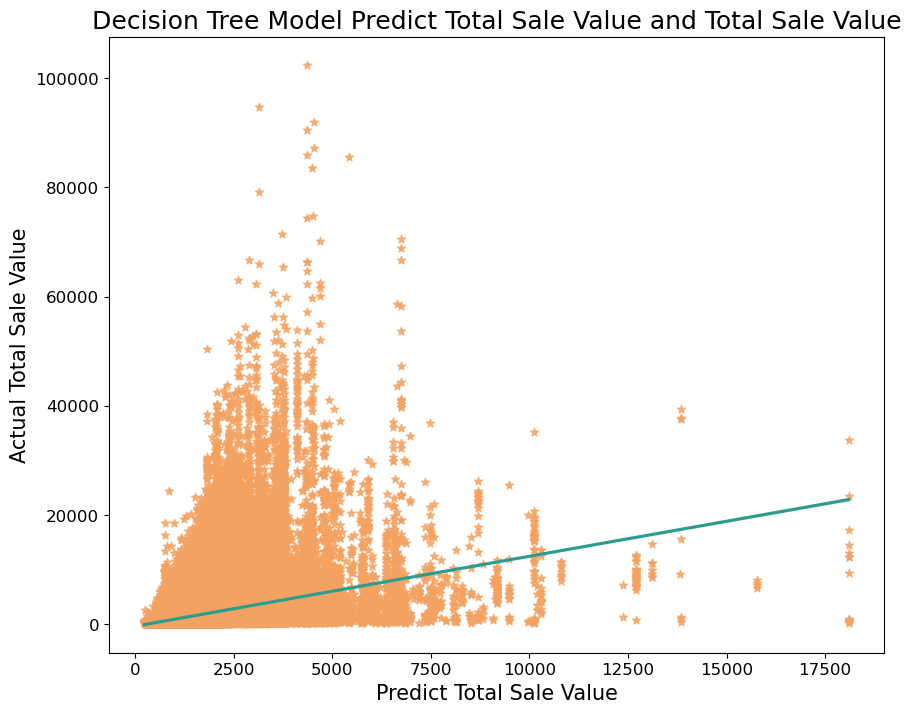

In [95]:
plt.figure(figsize = (10,8))
sns.regplot(x = Pvali_DTModel, 
            y = (vali_set['total_sale_value']), 
            marker = '*',
            color = '#F3A261',
            line_kws={'color':'#2A9D8E'})
plt.title('Decision Tree Model Predict Total Sale Value and Total Sale Value', fontsize = 18)
plt.xlabel('Predict Total Sale Value', fontsize = 15)
plt.ylabel('Actual Total Sale Value', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

### 5.5 Bagging

In [97]:
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import RandomizedSearchCV

param_dist = {'n_estimators': [10, 50, 100],
              'max_samples': [0.5, 1.0],
              'max_features': [0.5, 1.0],
              'bootstrap': [True, False],}

bagging = BaggingRegressor(random_state = 42)

random_search = RandomizedSearchCV(bagging, param_dist, n_iter = 50, cv = 3, n_jobs = -1, random_state = 42)
random_search.fit(X_train[sfl], y_train)

print("Best parameters: ", random_search.best_params_)

# source from QBUS6810

Best parameters:  {'n_estimators': 50, 'max_samples': 0.5, 'max_features': 0.5, 'bootstrap': True}


In [98]:
bagging_best_model = random_search.best_estimator_

bagging_best_pred = bagging_best_model.predict(X_vali[sfl])

In [99]:
Fit_BAGModel = bagging_best_model.predict(X_train[sfl])
Re_BAGModel = (np.exp(y_train - Fit_BAGModel)).mean()
Pvali_BAGModel = np.exp(bagging_best_pred) * Re_BAGModel
Pvali_BAGModel_r2_score = r2_score((vali_set['total_sale_value']), Pvali_BAGModel)
Pvali_BAGModel_rmse = np.sqrt(mse((vali_set['total_sale_value']), Pvali_BAGModel))

# source from QBUS6810

(array([-20000.,      0.,  20000.,  40000.,  60000.,  80000., 100000.,
        120000.]),
 [Text(0, -20000.0, '−20000'),
  Text(0, 0.0, '0'),
  Text(0, 20000.0, '20000'),
  Text(0, 40000.0, '40000'),
  Text(0, 60000.0, '60000'),
  Text(0, 80000.0, '80000'),
  Text(0, 100000.0, '100000'),
  Text(0, 120000.0, '120000')])

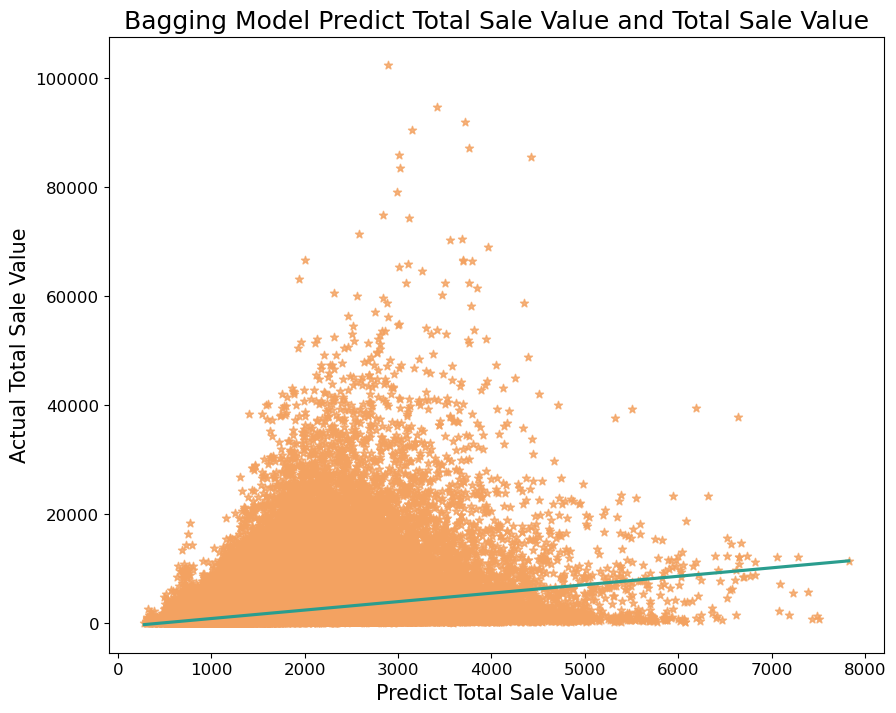

In [100]:
plt.figure(figsize = (10,8))
sns.regplot(x = Pvali_BAGModel, 
            y = (vali_set['total_sale_value']), 
            marker = '*',
            color = '#F3A261',
            line_kws = {'color':'#2A9D8E'})
plt.title('Bagging Model Predict Total Sale Value and Total Sale Value', fontsize = 18)
plt.xlabel('Predict Total Sale Value', fontsize = 15)
plt.ylabel('Actual Total Sale Value', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

### 5.6 Random Forest

In [101]:
from sklearn.ensemble import RandomForestRegressor

rf_param_dist = {'n_estimators': [50, 100, 200],
                 'max_depth': [None, 10, 20],
                 'min_samples_leaf': [1, 2],
                 'max_features': [None],}

rf_model_reduced = RandomForestRegressor()

rf_random_search = RandomizedSearchCV(estimator = rf_model_reduced, 
                                      param_distributions = rf_param_dist, 
                                      n_iter = 20, 
                                      cv = 3, 
                                      n_jobs = -1, 
                                      random_state = 42)

rf_random_search.fit(X_train[sfl], y_train)

print('Best parameters found with reduced search: ', rf_random_search.best_params_)

# source from QBUS6810

Best parameters found with reduced search:  {'n_estimators': 200, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 10}


In [102]:
rf_best_model = rf_random_search.best_estimator_

In [103]:
rf_model_pred = rf_best_model.predict(X_vali[sfl])

In [104]:
print(rf_best_model.feature_importances_)

[2.05102377e-01 6.32953804e-03 7.01882439e-02 2.68780829e-03
 8.60040442e-02 3.84381253e-03 3.91519783e-03 9.34571131e-03
 4.46891396e-04 8.63196818e-03 8.78975414e-04 2.31667197e-02
 9.73763850e-03 1.53790853e-02 5.54341989e-01]


In [105]:
Fit_RF = rf_best_model.predict(X_train[sfl])
Re_RF = (np.exp(y_train - Fit_RF)).mean()
Pvali_RF = np.exp(rf_model_pred) * Re_RF
Pvali_RF_r2_score = r2_score((vali_set['total_sale_value']), Pvali_RF)
Pvali_RF_rmse = np.sqrt(mse((vali_set['total_sale_value']), Pvali_RF))

# source from QBUS6810

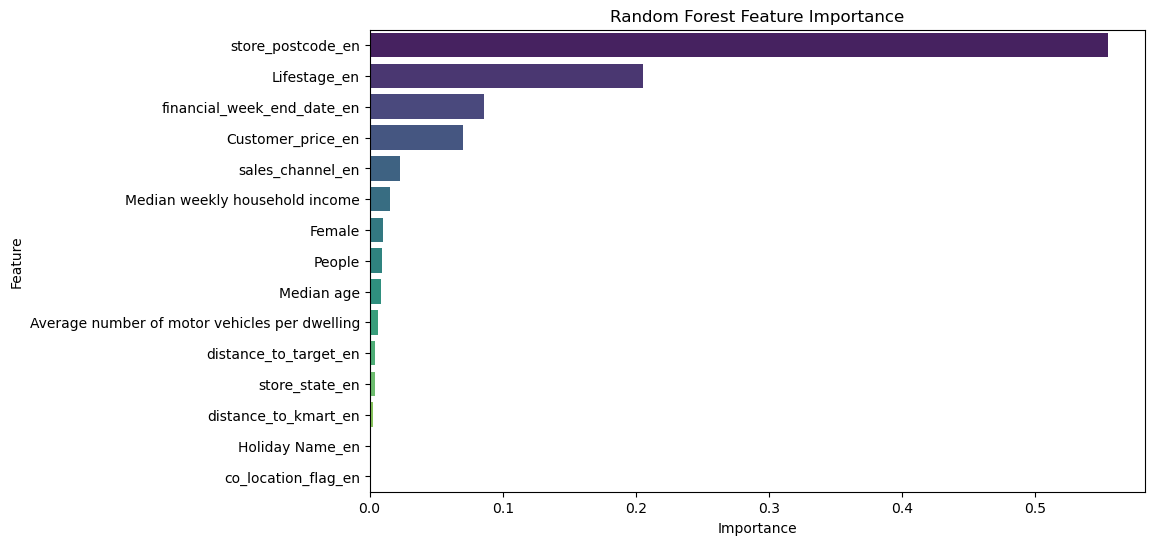

In [106]:
coefficients = pd.DataFrame({
    'Feature': X_train[sfl].columns,
    'Importance': rf_best_model.feature_importances_
}).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (10, 6))
sns.barplot(data = coefficients, x = 'Importance', y = 'Feature', palette = 'viridis')
plt.title('Random Forest Feature Importance')
plt.show()

(array([-20000.,      0.,  20000.,  40000.,  60000.,  80000., 100000.,
        120000.]),
 [Text(0, -20000.0, '−20000'),
  Text(0, 0.0, '0'),
  Text(0, 20000.0, '20000'),
  Text(0, 40000.0, '40000'),
  Text(0, 60000.0, '60000'),
  Text(0, 80000.0, '80000'),
  Text(0, 100000.0, '100000'),
  Text(0, 120000.0, '120000')])

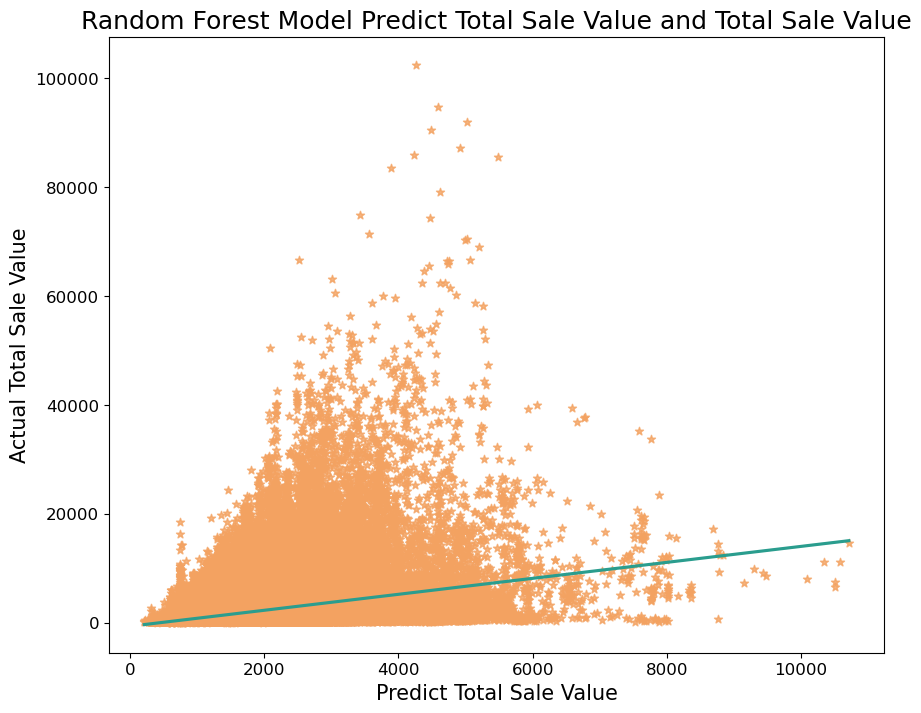

In [107]:
plt.figure(figsize = (10,8))
sns.regplot(x = Pvali_RF, 
            y = (vali_set['total_sale_value']), 
            marker = '*',
            color = '#F3A261',
            line_kws={'color':'#2A9D8E'})
plt.title('Random Forest Model Predict Total Sale Value and Total Sale Value', fontsize = 18)
plt.xlabel('Predict Total Sale Value', fontsize = 15)
plt.ylabel('Actual Total Sale Value', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

### 5.7 XGBoost

In [108]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

xgb = XGBRegressor(objective='reg:squarederror')

parameters = {'n_estimators': [2100, 2200, 2300],
              'learning_rate': [0.03, 0.04, 0.05],
              'max_depth': [9, 10, 11],
              'subsample': [0.87, 0.9, 0.93],
              'colsample_bytree': [0.87, 0.9, 0.93]}

xgb_search = RandomizedSearchCV(estimator = xgb,
                                param_distributions = parameters,
                                n_iter = 10,
                                cv = 3, 
                                scoring = 'neg_root_mean_squared_error', 
                                verbose = 2,
                                random_state = 42,
                                n_jobs = -1)
xgb_search.fit(X_train[sfl], y_train)

print(xgb_search.best_params_)

# source from QBUS6810

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'subsample': 0.87, 'n_estimators': 2300, 'max_depth': 9, 'learning_rate': 0.03, 'colsample_bytree': 0.87}


In [109]:
xgb_best_model = xgb_search.best_estimator_

In [110]:
xgb_pred = xgb_best_model.predict(X_vali[sfl])

In [111]:
print(xgb_best_model.feature_importances_)

[0.05259265 0.02336853 0.03555556 0.02731073 0.02623035 0.03353152
 0.0350289  0.03142595 0.02588351 0.04089763 0.01039714 0.0420836
 0.04055971 0.04585057 0.52928364]


In [112]:
Fit_XGB = xgb_best_model.predict(X_train[sfl])
Re_XGB = (np.exp(y_train - Fit_XGB)).mean()
Pvali_XGB = np.exp(xgb_pred) * Re_XGB
Pvali_XGB_r2_score = r2_score((vali_set['total_sale_value']), Pvali_XGB)
Pvali_XGB_rmse = np.sqrt(mse((vali_set['total_sale_value']), Pvali_XGB))

# source from QBUS6810

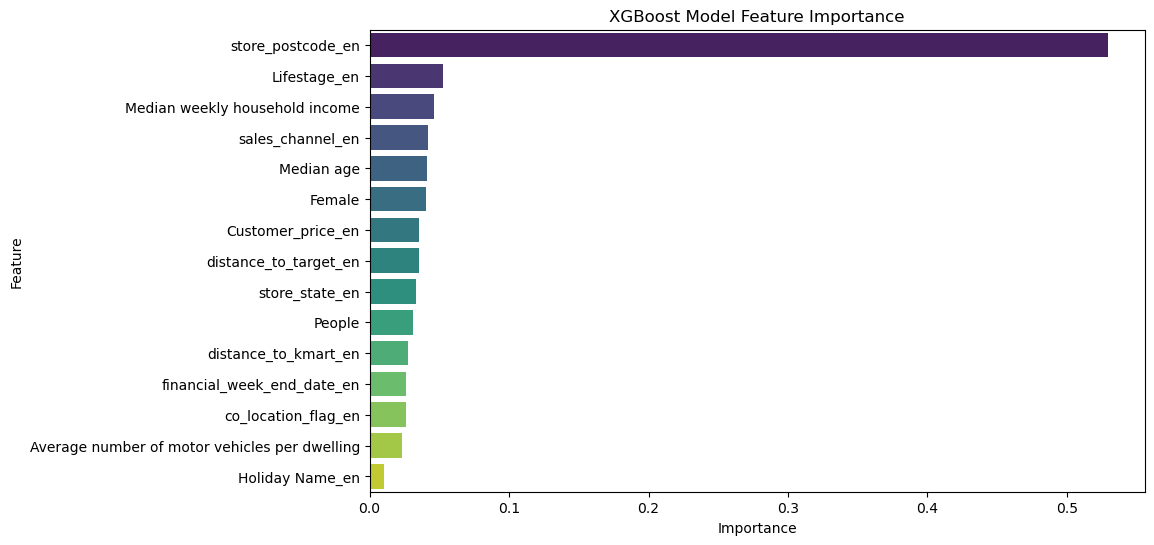

In [113]:
coefficients = pd.DataFrame({
    'Feature': X_train[sfl].columns,
    'Importance': xgb_best_model.feature_importances_
}).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (10, 6))
sns.barplot(data = coefficients, x = 'Importance', y = 'Feature', palette = 'viridis')
plt.title('XGBoost Model Feature Importance')
plt.show()

(array([-20000.,      0.,  20000.,  40000.,  60000.,  80000., 100000.,
        120000.]),
 [Text(0, -20000.0, '−20000'),
  Text(0, 0.0, '0'),
  Text(0, 20000.0, '20000'),
  Text(0, 40000.0, '40000'),
  Text(0, 60000.0, '60000'),
  Text(0, 80000.0, '80000'),
  Text(0, 100000.0, '100000'),
  Text(0, 120000.0, '120000')])

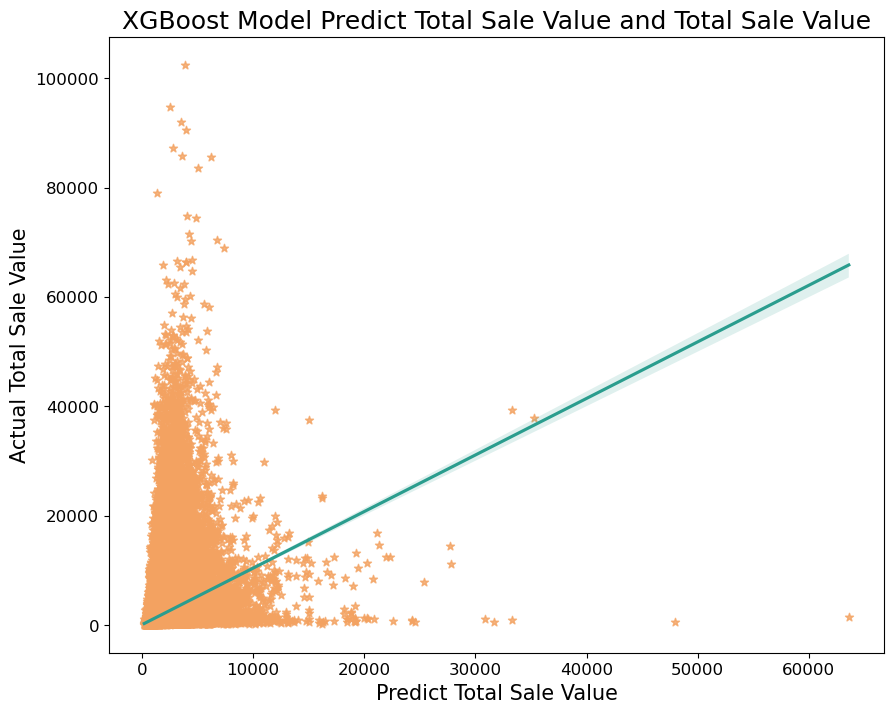

In [114]:
plt.figure(figsize = (10,8))
sns.regplot(x = Pvali_XGB, 
            y = (vali_set['total_sale_value']), 
            marker = '*',
            color = '#F3A261',
            line_kws={'color':'#2A9D8E'})
plt.title('XGBoost Model Predict Total Sale Value and Total Sale Value', fontsize = 18)
plt.xlabel('Predict Total Sale Value', fontsize = 15)
plt.ylabel('Actual Total Sale Value', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

# Model Evaluation

In [115]:
Retran_res = pd.DataFrame({'Model': ['OLS',
                                     'Lasso',
                                     'Elastic Net',
                                     'Decision Tree',
                                     'Bagging',
                                     'Random Forest',
                                     'XGBoost'],
                           'Validation RMSE' : [Pvali_OLSModel_rmse,
                                                Pvali_lasso_rmse,
                                                Pvali_ENModel_rmse,
                                                Pvali_DTModel_rmse,
                                                Pvali_BAGModel_rmse,
                                                Pvali_RF_rmse,
                                                Pvali_XGB_rmse],
                           'Validation R-Square': [Pvali_OLSModel_r2_score,
                                                   Pvali_lasso_r2_score,
                                                   Pvali_ENModel_r2_score,
                                                   Pvali_DTModel_r2_score,
                                                   Pvali_BAGModel_r2_score,
                                                   Pvali_RF_r2_score,
                                                   Pvali_XGB_r2_score]})

In [116]:
Retran_res

,Model,Validation RMSE,Validation R-Square
0,OLS,2609.11,0.11
1,Lasso,2743.99,0.01
2,Elastic Net,2743.99,0.01
3,Decision Tree,2588.56,0.12
4,Bagging,2639.20,0.09
5,Random Forest,2587.01,0.12
6,XGBoost,2617.17,0.10


# Test Best Model

In [117]:
rf_best_model.fit(X_tv[sfl], y_tv)

RandomForestRegressor(max_depth=10, max_features=None, n_estimators=200)

In [118]:
Final_model_pred = rf_best_model.predict(X_test[sfl])

In [119]:
Fit_final = rf_best_model.predict(X_tv[sfl])
Re_final = (np.exp(y_tv - Fit_final)).mean()
Pvali_final = np.exp(Final_model_pred) * Re_final
Pvali_final_r2_score = r2_score((BigW_test_data_new['total_sale_value']), Pvali_final)
Pvali_final_rmse = np.sqrt(mse((BigW_test_data_new['total_sale_value']), Pvali_final))

In [120]:
Pvali_final_rmse

2623.8015692732147

In [121]:
Pvali_final_r2_score

0.12174124547580822